In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_3208000/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"


In [3]:
import torch
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as patches
from scipy.stats import spearmanr
from sklearn.cross_decomposition import CCA
from sklearn import datasets
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
import mantel
from sknetwork.clustering import Louvain
from sklearn.cluster import DBSCAN
import harmonypy as hm
from harmony import harmonize

import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import label_dict
from label_dict import protein_to_num_single_cells, protein_to_num_full
from label_dict import hierarchical_organization_single_cell_low_level, hierarchical_organization_single_cell_high_level
from label_dict import hierarchical_organization_whole_image_low_level, hierarchical_organization_whole_image_high_level
from tqdm import tqdm
from scipy.stats import ttest_ind, zscore, norm
from statsmodels.stats.weightstats import ztest as ztest
from skimage import io
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, cdist
from seaborn import clustermap
from scipy.spatial.distance import squareform
import cuml
from sklearn.metrics import average_precision_score

cmap = cm.nipy_spectral


In [4]:
from sklearn.metrics import mutual_info_score

def create_bins(x):
    unique_xs = sorted(np.unique(x))
    bins = [unique_xs[0] - 0.5]
    for ind in range(len(unique_xs) - 1):
        bins.append(unique_xs[ind] + (unique_xs[ind + 1] - unique_xs[ind]) / 2)
    bins = bins + [unique_xs[-1] + 0.5]  
    return bins

def mutual_info(x,y,code_bin, factor_bin):
    c_xy = np.histogram2d(x,y,(code_bin, factor_bin))[0]
    mi = 0
    N = np.sum(c_xy)
    for i in range(c_xy.shape[0]):
        for j in range(c_xy.shape[1]):
            p_i = np.sum(c_xy[i,:]) / N
            p_j = np.sum(c_xy[:,j]) / N
            p_ij = c_xy[i,j] / N
            if p_ij == 0: 
                mi += 0 
            else:
                mi += (p_ij) * np.log(p_ij / (p_i * p_j))
    return mi

def conditional_mutual_info(x,y,z,bins):
    c_xyz = np.histogramdd((x, 
                          y, 
                          z),
                          bins)[0]
    N = np.sum(c_xyz)
    mi = 0
    p_z = c_xyz.sum(axis=(0,1)) / N
    p_iz = c_xyz.sum(axis=(1)) / N
    p_jz = c_xyz.sum(axis=(0)) / N
    p_ijzs = c_xyz / N
    N = np.sum(c_xyz)
    for i in (range(c_xyz.shape[0])):
        for j in range(c_xyz.shape[1]):
            for z in range(c_xyz.shape[2]):
                if p_ijzs[i,j,z] == 0: 
                    mi += 0 
                else:
                    mi += (p_ijzs[i,j,z]) * np.log((p_z[z] * p_ijzs[i,j,z]) / (p_iz[i,z] * p_jz[j,z]))
    return mi    


def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def get_col_matrix(df, labels):
    if len(labels) == 1:
        values = df[labels[0]]
        unique_values = sorted(np.unique(values))
        mat = np.zeros((len(df), len(unique_values)))
        for ind, value in enumerate(unique_values):
            mat[np.where(values == value)[0], ind] = 1
        columns = unique_values
    else:
        mat = df[sorted(labels)].values.astype(int)
        columns = sorted(labels)
    return mat, columns

In [ ]:
config_files = [
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_engineered.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_3_channel.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_pretrained_combined.yaml',
               ]
labels = [
    'Engineered features',
    'DINO trained',
    'DINO pretrained',
             ]

label_types = [
    'single_cells',
    'single_cells',
    'single_cells',
              ]

feature_types = [
    'full',
    'full',
    'full',
              ]

config = yaml.safe_load(open(config_files[0], "r"))
df = pd.read_csv(config['embedding']['df_path'])
try:
    features, _, IDs = torch.load(config['embedding']['output_path'])            
except:
    features, IDs = torch.load(config['embedding']['output_path'])            
      
factor_gaps_per_method = []
allen_mi_matrices = []
code_bins = [6]
factor_bins = [6]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for config_file, label in zip(config_files, labels):
        config = yaml.safe_load(open(config_file, "r"))
        df = pd.read_csv(config['embedding']['df_path'])
        try:
            features, _, IDs = torch.load(config['embedding']['output_path'])            
        except:
            features, IDs = torch.load(config['embedding']['output_path'])            
#         pca = decomposition.PCA(n_components=100)
#         reduced_features = pca.fit_transform(features)
        reduced_features = features

        well_mat, well_labels = get_col_matrix(df, ['WellId'])    
        structure_mat, structure_labels = get_col_matrix(df, ['Structure'])    
        stage_mat, stage_labels = get_col_matrix(df, ['cell_stage'])    
        factors = np.stack((np.argmax(structure_mat, axis=1),
                        np.argmax(stage_mat, axis=1),
                        np.argmax(well_mat, axis=1))).T
        codes = torch.Tensor(reduced_features)

        allen_protein_MI = []
        allen_cell_MI = []
        allen_well_MI = []

        for i in tqdm(range(codes.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            allen_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            allen_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            allen_well_MI.append(well_mi)      
        mi_matrix = np.stack((allen_protein_MI, allen_cell_MI, allen_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        allen_mi_matrices.append(mi_matrix)

  6%|█████████▊                                                                                                                                                    | 190/3072 [00:04<01:12, 39.62it/s]

In [5]:
config_files = [
    '/scr/mdoron/Dino4Cells/configs/config_hpa_single_cell_4_channels.yaml',    
    '/scr/mdoron/Dino4Cells/configs/config_hpa_single_cell_4_channels.yaml',    
    '/scr/mdoron/Dino4Cells/configs/config_tta.yaml',
#     '/scr/mdoron/Dino4Cells/configs/config_pretrained.yaml',    
               ]
labels = [
    'Trained DINO',
    'Trained DINO, harmonized',
    'Dualhead',
#     'Pretrained DINO',    
             ]

single_model_labels = labels
single_mi_matrices = []
factor_gaps_per_method = []
code_bins = [25]
factor_bins = [25]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for config_file, label in zip(config_files, labels):
        config = yaml.safe_load(open(config_file, "r"))
        df = pd.read_csv(config['embedding']['df_path'])
        features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
        try:
            protein_localizations = torch.stack(protein_localizations)
        except:
            pass
        protein_localizations = torch.Tensor(protein_localizations)
        
        pca = decomposition.PCA(n_components=100)
        features = pca.fit_transform(features)
        
        one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
        website_indices = np.where(df.ID.str.contains('_'))[0]
        website_features = features[website_indices,:]
        website_df = df.iloc[website_indices].reset_index()
        website_df['plate'] = website_df.ID.str.split('_', expand=True)[0].values
        website_df['well'] = website_df.ID.str.split('_', expand=True)[1].values
        website_proteins = protein_localizations[website_indices]                
        cell_mat, cell_labels = get_col_matrix(df, ['cell_type'])    
        website_cell = cell_mat[website_indices]
        one_protein_indices = np.where(website_proteins.sum(axis=1) == 1)[0]
        if 'harmonized' in label:
            website_features = harmonize(torch.Tensor(website_features).numpy(), 
                                            website_df,
                                            batch_key = ['cell_type'], 
                                            use_gpu=True,
                                            random_state=42,
            )
            
        website_features = torch.Tensor(website_features)
        website_features -= website_features.min(axis=0)[0]
        website_features /= website_features.max(axis=0)[0]
        
        factors = np.stack((
            np.argmax(website_proteins[one_protein_indices], axis=1).numpy(),
            np.argmax(website_cell[one_protein_indices], axis=1),
            website_df['well'].values[one_protein_indices].astype(int))
        ).T
        codes = website_features[one_protein_indices]

        whole_HPA_protein_MI = []
        whole_HPA_cell_MI = []
        whole_HPA_well_MI = []

        for i in tqdm(range(website_features.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            whole_HPA_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            whole_HPA_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            whole_HPA_well_MI.append(well_mi)      
        mi_matrix = np.stack((whole_HPA_protein_MI, whole_HPA_cell_MI, whole_HPA_well_MI))
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        single_mi_matrices.append(mi_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 23.49it/s]


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
Reach convergence after 5 iteration(s).


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.60it/s]


([<matplotlib.axis.XTick at 0x7f5b939a8880>,
 [Text(0, 0, 'Trained DINO'),
  Text(1, 0, 'Trained DINO, harmonized'),
  Text(2, 0, 'Dualhead')])

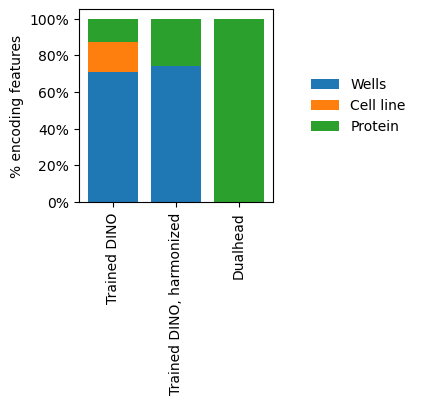

In [15]:
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
cmap = cm.nipy_spectral

dominant_fov_percentages = []
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(single_mi_matrices, single_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    dominant_fov_percentage = [len(high_protein) / len(new_indices),
                               len(high_cell) / len(new_indices),
                               len(high_well) / len(new_indices),]
    dominant_fov_percentages.append(dominant_fov_percentage)
                               
dominant_fov_percentages = np.array(dominant_fov_percentages) * 100
dominant_fov_percentages = dominant_fov_percentages[:,np.argsort(dominant_fov_percentages[0,:])[::-1]]
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = 0,
    height = dominant_fov_percentages[:,0],
    label='Wells'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:1].sum(axis=1),
    height = dominant_fov_percentages[:,1],
    label='Cell line'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:2].sum(axis=1),
    height = dominant_fov_percentages[:,2],
    label='Protein'
       )
plt.legend(bbox_to_anchor=(1.75,0.5), loc='center right', frameon=False)
plt.ylabel('% encoding features')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(single_model_labels)),single_model_labels, rotation=90)

array([[ 71.,  16.,  13.],
       [ 74.,   0.,  26.],
       [  0.,   0., 100.]])

In [65]:
config_files = [
    '/scr/mdoron/Dino4Cells/configs/config_bestfitting_whole.yaml',
    '/scr/mdoron/Dino4Cells/configs/config_FAIR_whole_image_all_channels.yaml',
    '/scr/mdoron/Dino4Cells/configs/config_FAIR_whole_image_all_channels.yaml',
#     '/scr/mdoron/Dino4Cells/configs/config_pretrained_whole_combined.yaml',
#     '/scr/mdoron/Dino4Cells/configs/config_FAIR_supervised_whole_image_model.yaml',
               ]

labels = [
    'Bestfitting',
    'Trained DINO',
    'Trained DINO,\nharmonized',
#     'Whole image, pretrained DINO',
#     'Whole image, supervised ViT',
             ]

label_types = [
    'whole_image',
    'whole_image',
    'whole_image',
#     'whole_image',
#     'whole_image',
              ]

feature_types = [
    'full',
    'full',
    'full',
#     'full',    
#     'full',    
              ]

hpa_model_labels = labels
hpa_mi_matrices = []
factor_gaps_per_method = []
code_bins = [25]
factor_bins = [25]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for config_file, label in zip(config_files, labels):
        config = yaml.safe_load(open(config_file, "r"))
        df = pd.read_csv(config['embedding']['df_path'])
        features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
        try:
            protein_localizations = torch.stack(protein_localizations)
        except:
            pass
        protein_localizations = torch.Tensor(protein_localizations)

        one_protein_indices = np.where(protein_localizations.sum(axis=1) == 1)[0]
        website_indices = np.where(df.ID.str.contains('_'))[0]
        website_features = features[website_indices,:]
        website_df = df.iloc[website_indices].reset_index()
        website_df['plate'] = website_df.ID.str.split('_', expand=True)[0].values
        website_df['well'] = website_df.ID.str.split('_', expand=True)[1].values
        website_proteins = protein_localizations[website_indices]
        cell_mat, cell_labels = get_col_matrix(df, ['cell_type'])    
        website_cell = cell_mat[website_indices]
        one_protein_indices = np.where(website_proteins.sum(axis=1) == 1)[0]
        if 'harmonized' in label:
            website_features = harmonize(torch.Tensor(website_features).numpy(), 
                                            website_df,
                                            batch_key = ['cell_type'], 
                                            use_gpu=True,
                                            random_state=42,
            )        
        
        website_features -= website_features.min(axis=0)[0]
        website_features /= website_features.max(axis=0)[0]

        factors = np.stack((np.argmax(website_proteins[one_protein_indices], axis=1).numpy(),
                        np.argmax(website_cell[one_protein_indices], axis=1),
                        website_df['well'].values[one_protein_indices].astype(int))).T
        codes = torch.Tensor(website_features[one_protein_indices])

        whole_HPA_protein_MI = []
        whole_HPA_cell_MI = []
        whole_HPA_well_MI = []

        for i in tqdm(range(website_features.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            whole_HPA_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            whole_HPA_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            whole_HPA_well_MI.append(well_mi)      
        mi_matrix = np.stack((whole_HPA_protein_MI, whole_HPA_cell_MI, whole_HPA_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        hpa_mi_matrices.append(mi_matrix)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:15<00:00, 48.12it/s]


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:15<00:00, 49.06it/s]


([<matplotlib.axis.XTick at 0x7f5552240700>,
 [Text(0, 0, 'Bestfitting'),
  Text(1, 0, 'Trained DINO'),
  Text(2, 0, 'Trained DINO,\nharmonized')])

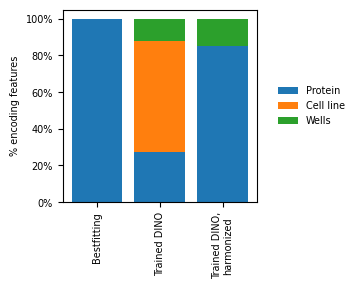

In [70]:
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
cmap = cm.nipy_spectral

dominant_fov_percentages = []
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(hpa_mi_matrices, hpa_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    dominant_fov_percentage = [len(high_protein) / len(new_indices),
                               len(high_cell) / len(new_indices),
                               len(high_well) / len(new_indices),]
    dominant_fov_percentages.append(dominant_fov_percentage)
                               
dominant_fov_percentages = np.array(dominant_fov_percentages) * 100
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = 0,
    height = dominant_fov_percentages[:,0],
    label='Protein'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:1].sum(axis=1),
    height = dominant_fov_percentages[:,1],
    label='Cell line'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:2].sum(axis=1),
    height = dominant_fov_percentages[:,2],
    label='Wells'
       )
plt.legend(bbox_to_anchor=(1.5,0.5), loc='center right', frameon=False)
plt.ylabel('% encoding features')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(hpa_model_labels)),hpa_model_labels, rotation=90)

In [ ]:
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
cmap = cm.nipy_spectral

dominant_fov_percentages = []
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(hpa_mi_matrices, hpa_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    dominant_fov_percentage = [len(high_protein) / len(new_indices),
                               len(high_cell) / len(new_indices),
                               len(high_well) / len(new_indices),]
    dominant_fov_percentages.append(dominant_fov_percentage)
                               
dominant_fov_percentages = np.array(dominant_fov_percentages) * 100
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = 0,
    height = dominant_fov_percentages[:,0],
    label='Protein'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:1].sum(axis=1),
    height = dominant_fov_percentages[:,1],
    label='Cell line'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:2].sum(axis=1),
    height = dominant_fov_percentages[:,2],
    label='Wells'
       )
plt.legend(bbox_to_anchor=(1.5,0.5), loc='center right', frameon=False)
plt.ylabel('% encoding features')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(single_model_labels)),single_model_labels, rotation=90)

In [16]:
config_files = [
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_3_channel.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_pretrained_combined.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_engineered.yaml',
               ]
labels = [
    'DINO trained',
    'DINO pretrained',
    'Engineered features',
             ]

label_types = [
    'single_cells',
    'single_cells',
    'single_cells',
              ]

feature_types = [
    'full',
    'full',
    'full',
              ]

config = yaml.safe_load(open(config_files[0], "r"))
df = pd.read_csv(config['embedding']['df_path'])
try:
    features, _, IDs = torch.load(config['embedding']['output_path'])            
except:
    features, IDs = torch.load(config['embedding']['output_path'])            

factor_gaps_per_method = []
allen_mi_matrices = []
code_bins = [6]
factor_bins = [6]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for config_file, label in zip(config_files, labels):
        config = yaml.safe_load(open(config_file, "r"))
        df = pd.read_csv(config['embedding']['df_path'])
        try:
            features, _, IDs = torch.load(config['embedding']['output_path'])            
        except:
            features, IDs = torch.load(config['embedding']['output_path'])            
#         pca = decomposition.PCA(n_components=100)
#         reduced_features = pca.fit_transform(features)
        reduced_features = features

        well_mat, well_labels = get_col_matrix(df, ['WellId'])    
        structure_mat, structure_labels = get_col_matrix(df, ['Structure'])    
        stage_mat, stage_labels = get_col_matrix(df, ['cell_stage'])    
        factors = np.stack((np.argmax(structure_mat, axis=1),
                        np.argmax(stage_mat, axis=1),
                        np.argmax(well_mat, axis=1))).T
        codes = torch.Tensor(reduced_features)

        allen_protein_MI = []
        allen_cell_MI = []
        allen_well_MI = []

        for i in tqdm(range(codes.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            allen_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            allen_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            allen_well_MI.append(well_mi)      
        mi_matrix = np.stack((allen_protein_MI, allen_cell_MI, allen_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        allen_mi_matrices.append(mi_matrix)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 65.95it/s]


In [75]:
config_files = [
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_engineered.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_3_channel.yaml',
    '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_3_channel.yaml',
#     '/scr/mdoron/allen/cytodata-hackathon-base/Cytodata_DINO/config_pretrained_combined.yaml',
               ]
labels = [
    'Engineered features',
    'Trained DINO',
    'Trained DINO,\nharmonized',
#     'DINO pretrained',
             ]

config = yaml.safe_load(open(config_files[0], "r"))
df = pd.read_csv(config['embedding']['df_path'])
try:
    features, _, IDs = torch.load(config['embedding']['output_path'])            
except:
    features, IDs = torch.load(config['embedding']['output_path'])            
      
factor_gaps_per_method = []
allen_mi_matrices = []
allen_model_labels = labels
code_bins = [6]
factor_bins = [6]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for config_file, label in zip(config_files, labels):
        config = yaml.safe_load(open(config_file, "r"))
        df = pd.read_csv(config['embedding']['df_path'])
        try:
            features, _, IDs = torch.load(config['embedding']['output_path'])            
        except:
            features, IDs = torch.load(config['embedding']['output_path'])            
#         pca = decomposition.PCA(n_components=100)
#         reduced_features = pca.fit_transform(features)
        reduced_features = features
    
        if 'harmonized' in label:
            reduced_features = harmonize(torch.Tensor(reduced_features).numpy(), 
                                            df,
                                            batch_key = ['Structure'], 
                                            use_gpu=True,
                                            random_state=42,
            )        
            

        well_mat, well_labels = get_col_matrix(df, ['WellId'])    
        structure_mat, structure_labels = get_col_matrix(df, ['Structure'])    
        stage_mat, stage_labels = get_col_matrix(df, ['cell_stage'])    
        factors = np.stack((np.argmax(structure_mat, axis=1),
                        np.argmax(stage_mat, axis=1),
                        np.argmax(well_mat, axis=1))).T
        codes = torch.Tensor(reduced_features)

        allen_protein_MI = []
        allen_cell_MI = []
        allen_well_MI = []

        for i in tqdm(range(codes.shape[1])):
            protein_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            allen_protein_MI.append(protein_mi)
            cell_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            allen_cell_MI.append(cell_mi)    
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,2], code_bin, factor_bin)
            allen_well_MI.append(well_mi)      
        mi_matrix = np.stack((allen_protein_MI, allen_cell_MI, allen_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        allen_mi_matrices.append(mi_matrix)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:19<00:00, 39.39it/s]


Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
Reach convergence after 3 iteration(s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [00:19<00:00, 38.78it/s]


In [19]:
allen_model_labels = labels

([<matplotlib.axis.XTick at 0x7f5b909eaf70>,
 [Text(0, 0, 'DINO trained'),
  Text(1, 0, 'DINO pretrained'),
  Text(2, 0, 'Engineered features')])

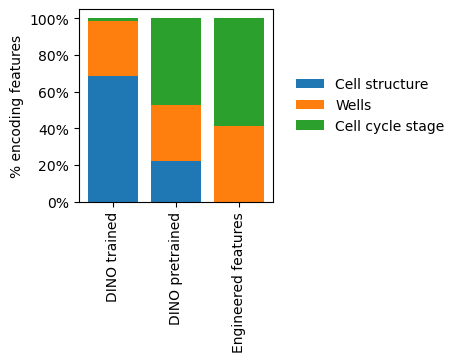

In [22]:
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
cmap = cm.nipy_spectral

dominant_fov_percentages = []
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(allen_mi_matrices, allen_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    dominant_fov_percentage = [len(high_protein) / len(new_indices),
                               len(high_cell) / len(new_indices),
                               len(high_well) / len(new_indices),]
    dominant_fov_percentages.append(dominant_fov_percentage)
                               
dominant_fov_percentages = np.array(dominant_fov_percentages) * 100
dominant_fov_percentages = dominant_fov_percentages[:,np.argsort(dominant_fov_percentages[0,:])[::-1]]
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = 0,
    height = dominant_fov_percentages[:,0],
    label='Cell structure'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:1].sum(axis=1),
    height = dominant_fov_percentages[:,1],
    label='Wells'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:2].sum(axis=1),
    height = dominant_fov_percentages[:,2],
    label='Cell cycle stage'
       )
plt.legend(bbox_to_anchor=(1.95,0.5), loc='center right', frameon=False)
plt.ylabel('% encoding features')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(allen_model_labels)),allen_model_labels, rotation=90)


In [163]:
df_LINCS = pd.read_csv('/scr/mdoron/Dino4Cells/UMAP_of_LINCS_ViT_Small_Compressed.csv')
features_LINCS = df_LINCS[[f'{i}' for i in range(384)]].values

df_combined = pd.read_csv('/scr/mdoron/Dino4Cells/UMAP_of_Combined_CP.csv')
features_combined = torch.load('/scr/mdoron/Dino4Cells/cell_painting_subset.pth')

df_cellprofiler = pd.read_csv('cp_cellprofiler_full.csv')
df_cellprofiler['Well'] = df_cellprofiler['Metadata_Well']
df_cellprofiler['Treatment'] = df_cellprofiler['Metadata_pert_id']
features_cellprofiler = df_cellprofiler[['Cells_AreaShape_Compactness',
 'Cells_AreaShape_Eccentricity',
 'Cells_AreaShape_Extent',
 'Cells_AreaShape_FormFactor',
 'Cells_AreaShape_Orientation',
 'Cells_AreaShape_Solidity',
 'Cells_AreaShape_Zernike_0_0',
 'Cells_AreaShape_Zernike_1_1',
 'Cells_AreaShape_Zernike_2_0',
 'Cells_AreaShape_Zernike_2_2',
 'Cells_AreaShape_Zernike_3_1',
 'Cells_AreaShape_Zernike_3_3',
 'Cells_AreaShape_Zernike_4_0',
 'Cells_AreaShape_Zernike_4_2',
 'Cells_AreaShape_Zernike_4_4',
 'Cells_AreaShape_Zernike_5_1',
 'Cells_AreaShape_Zernike_5_3',
 'Cells_AreaShape_Zernike_5_5',
 'Cells_AreaShape_Zernike_6_0',
 'Cells_AreaShape_Zernike_6_2',
 'Cells_AreaShape_Zernike_6_4',
 'Cells_AreaShape_Zernike_6_6',
 'Cells_AreaShape_Zernike_7_1',
 'Cells_AreaShape_Zernike_7_3',
 'Cells_AreaShape_Zernike_7_7',
 'Cells_AreaShape_Zernike_8_0',
 'Cells_AreaShape_Zernike_8_2',
 'Cells_AreaShape_Zernike_8_4',
 'Cells_AreaShape_Zernike_8_8',
 'Cells_AreaShape_Zernike_9_1',
 'Cells_AreaShape_Zernike_9_3',
 'Cells_AreaShape_Zernike_9_5',
 'Cells_AreaShape_Zernike_9_9',
 'Cells_Correlation_Correlation_DNA_AGP',
 'Cells_Correlation_Correlation_DNA_ER',
 'Cells_Correlation_Correlation_DNA_Mito',
 'Cells_Correlation_Correlation_DNA_RNA',
 'Cells_Correlation_Correlation_ER_AGP',
 'Cells_Correlation_Correlation_ER_RNA',
 'Cells_Correlation_Correlation_Mito_AGP',
 'Cells_Correlation_Correlation_Mito_ER',
 'Cells_Correlation_Correlation_Mito_RNA',
 'Cells_Correlation_Correlation_RNA_AGP',
 'Cells_Correlation_Costes_DNA_Mito',
 'Cells_Correlation_Costes_DNA_RNA',
 'Cells_Correlation_K_AGP_DNA',
 'Cells_Correlation_K_DNA_AGP',
 'Cells_Correlation_K_DNA_ER',
 'Cells_Correlation_K_ER_AGP',
 'Cells_Correlation_K_ER_DNA',
 'Cells_Correlation_K_ER_RNA',
 'Cells_Correlation_K_Mito_DNA',
 'Cells_Correlation_K_RNA_ER',
 'Cells_Correlation_Manders_AGP_DNA',
 'Cells_Correlation_Manders_AGP_Mito',
 'Cells_Correlation_Manders_ER_DNA',
 'Cells_Correlation_Manders_Mito_DNA',
 'Cells_Correlation_Manders_Mito_RNA',
 'Cells_Correlation_Manders_RNA_DNA',
 'Cells_Correlation_Manders_RNA_Mito',
 'Cells_Correlation_Overlap_DNA_AGP',
 'Cells_Correlation_Overlap_DNA_ER',
 'Cells_Correlation_Overlap_DNA_Mito',
 'Cells_Correlation_Overlap_DNA_RNA',
 'Cells_Correlation_Overlap_ER_AGP',
 'Cells_Correlation_Overlap_ER_RNA',
 'Cells_Correlation_Overlap_Mito_AGP',
 'Cells_Correlation_Overlap_Mito_RNA',
 'Cells_Correlation_Overlap_RNA_AGP',
 'Cells_Correlation_RWC_AGP_ER',
 'Cells_Correlation_RWC_AGP_RNA',
 'Cells_Correlation_RWC_DNA_AGP',
 'Cells_Correlation_RWC_DNA_ER',
 'Cells_Correlation_RWC_DNA_Mito',
 'Cells_Correlation_RWC_DNA_RNA',
 'Cells_Correlation_RWC_ER_AGP',
 'Cells_Correlation_RWC_ER_RNA',
 'Cells_Correlation_RWC_RNA_AGP',
 'Cells_Correlation_RWC_RNA_ER',
 'Cells_Granularity_11_ER',
 'Cells_Granularity_11_RNA',
 'Cells_Granularity_12_ER',
 'Cells_Granularity_12_RNA',
 'Cells_Granularity_13_AGP',
 'Cells_Granularity_13_ER',
 'Cells_Granularity_13_Mito',
 'Cells_Granularity_13_RNA',
 'Cells_Granularity_14_AGP',
 'Cells_Granularity_14_ER',
 'Cells_Granularity_14_Mito',
 'Cells_Granularity_14_RNA',
 'Cells_Granularity_15_RNA',
 'Cells_Granularity_2_AGP',
 'Cells_Granularity_2_ER',
 'Cells_Granularity_2_Mito',
 'Cells_Granularity_2_RNA',
 'Cells_Granularity_3_AGP',
 'Cells_Granularity_3_ER',
 'Cells_Granularity_3_Mito',
 'Cells_Granularity_3_RNA',
 'Cells_Granularity_4_ER',
 'Cells_Granularity_4_RNA',
 'Cells_Granularity_5_AGP',
 'Cells_Granularity_5_Mito',
 'Cells_Granularity_6_AGP',
 'Cells_Granularity_6_ER',
 'Cells_Granularity_6_Mito',
 'Cells_Granularity_7_AGP',
 'Cells_Granularity_8_AGP',
 'Cells_Intensity_IntegratedIntensityEdge_AGP',
 'Cells_Intensity_IntegratedIntensityEdge_Mito',
 'Cells_Intensity_IntegratedIntensity_AGP',
 'Cells_Intensity_IntegratedIntensity_DNA',
 'Cells_Intensity_IntegratedIntensity_ER',
 'Cells_Intensity_IntegratedIntensity_RNA',
 'Cells_Intensity_MADIntensity_AGP',
 'Cells_Intensity_MADIntensity_DNA',
 'Cells_Intensity_MADIntensity_ER',
 'Cells_Intensity_MADIntensity_RNA',
 'Cells_Intensity_MassDisplacement_AGP',
 'Cells_Intensity_MassDisplacement_DNA',
 'Cells_Intensity_MassDisplacement_ER',
 'Cells_Intensity_MassDisplacement_Mito',
 'Cells_Intensity_MassDisplacement_RNA',
 'Cells_Intensity_MaxIntensityEdge_ER',
 'Cells_Intensity_MaxIntensityEdge_Mito',
 'Cells_Intensity_MaxIntensity_AGP',
 'Cells_Intensity_MaxIntensity_RNA',
 'Cells_Intensity_MeanIntensityEdge_AGP',
 'Cells_Intensity_MeanIntensityEdge_Mito',
 'Cells_Intensity_MeanIntensity_AGP',
 'Cells_Intensity_MeanIntensity_DNA',
 'Cells_Intensity_MeanIntensity_ER',
 'Cells_Intensity_MedianIntensity_DNA',
 'Cells_Intensity_MedianIntensity_RNA',
 'Cells_Intensity_MinIntensityEdge_RNA',
 'Cells_Intensity_MinIntensity_AGP',
 'Cells_Intensity_StdIntensityEdge_AGP',
 'Cells_Intensity_StdIntensityEdge_DNA',
 'Cells_Intensity_StdIntensityEdge_ER',
 'Cells_Intensity_StdIntensityEdge_Mito',
 'Cells_Intensity_StdIntensityEdge_RNA',
 'Cells_Intensity_StdIntensity_DNA',
 'Cells_Intensity_StdIntensity_ER',
 'Cells_Intensity_StdIntensity_RNA',
 'Cells_Intensity_UpperQuartileIntensity_DNA',
 'Cells_Intensity_UpperQuartileIntensity_RNA',
 'Cells_Neighbors_FirstClosestDistance_10',
 'Cells_Neighbors_PercentTouching_Adjacent',
 'Cells_Neighbors_SecondClosestObjectNumber_Adjacent',
 'Cells_RadialDistribution_FracAtD_AGP_1of4',
 'Cells_RadialDistribution_FracAtD_AGP_3of4',
 'Cells_RadialDistribution_FracAtD_ER_1of4',
 'Cells_RadialDistribution_FracAtD_ER_3of4',
 'Cells_RadialDistribution_FracAtD_Mito_1of4',
 'Cells_RadialDistribution_FracAtD_Mito_3of4',
 'Cells_RadialDistribution_FracAtD_RNA_3of4',
 'Cells_RadialDistribution_FracAtD_RNA_4of4',
 'Cells_RadialDistribution_MeanFrac_AGP_1of4',
 'Cells_RadialDistribution_MeanFrac_AGP_2of4',
 'Cells_RadialDistribution_MeanFrac_AGP_3of4',
 'Cells_RadialDistribution_MeanFrac_ER_1of4',
 'Cells_RadialDistribution_MeanFrac_ER_3of4',
 'Cells_RadialDistribution_MeanFrac_ER_4of4',
 'Cells_RadialDistribution_MeanFrac_Mito_1of4',
 'Cells_RadialDistribution_MeanFrac_Mito_3of4',
 'Cells_RadialDistribution_MeanFrac_Mito_4of4',
 'Cells_RadialDistribution_MeanFrac_RNA_1of4',
 'Cells_RadialDistribution_MeanFrac_RNA_3of4',
 'Cells_RadialDistribution_RadialCV_AGP_1of4',
 'Cells_RadialDistribution_RadialCV_AGP_2of4',
 'Cells_RadialDistribution_RadialCV_AGP_3of4',
 'Cells_RadialDistribution_RadialCV_AGP_4of4',
 'Cells_RadialDistribution_RadialCV_ER_1of4',
 'Cells_RadialDistribution_RadialCV_ER_2of4',
 'Cells_RadialDistribution_RadialCV_ER_3of4',
 'Cells_RadialDistribution_RadialCV_ER_4of4',
 'Cells_RadialDistribution_RadialCV_Mito_1of4',
 'Cells_RadialDistribution_RadialCV_Mito_2of4',
 'Cells_RadialDistribution_RadialCV_Mito_3of4',
 'Cells_RadialDistribution_RadialCV_Mito_4of4',
 'Cells_RadialDistribution_RadialCV_RNA_1of4',
 'Cells_RadialDistribution_RadialCV_RNA_2of4',
 'Cells_RadialDistribution_RadialCV_RNA_3of4',
 'Cells_RadialDistribution_RadialCV_RNA_4of4',
 'Cells_Texture_AngularSecondMoment_AGP_5_0',
 'Cells_Texture_AngularSecondMoment_DNA_5_0',
 'Cells_Texture_AngularSecondMoment_Mito_20_0',
 'Cells_Texture_AngularSecondMoment_RNA_20_0',
 'Cells_Texture_Contrast_Mito_10_0',
 'Cells_Texture_Contrast_Mito_20_0',
 'Cells_Texture_Contrast_Mito_5_0',
 'Cells_Texture_Correlation_AGP_10_0',
 'Cells_Texture_Correlation_AGP_20_0',
 'Cells_Texture_Correlation_AGP_5_0',
 'Cells_Texture_Correlation_DNA_5_0',
 'Cells_Texture_Correlation_ER_10_0',
 'Cells_Texture_Correlation_ER_20_0',
 'Cells_Texture_Correlation_ER_5_0',
 'Cells_Texture_Correlation_Mito_10_0',
 'Cells_Texture_Correlation_Mito_20_0',
 'Cells_Texture_Correlation_Mito_5_0',
 'Cells_Texture_Correlation_RNA_10_0',
 'Cells_Texture_Correlation_RNA_20_0',
 'Cells_Texture_Correlation_RNA_5_0',
 'Cells_Texture_DifferenceEntropy_AGP_5_0',
 'Cells_Texture_DifferenceEntropy_ER_20_0',
 'Cells_Texture_DifferenceEntropy_Mito_10_0',
 'Cells_Texture_DifferenceEntropy_Mito_20_0',
 'Cells_Texture_DifferenceVariance_DNA_5_0',
 'Cells_Texture_DifferenceVariance_Mito_10_0',
 'Cells_Texture_DifferenceVariance_Mito_20_0',
 'Cells_Texture_DifferenceVariance_Mito_5_0',
 'Cells_Texture_DifferenceVariance_RNA_20_0',
 'Cells_Texture_Entropy_Mito_20_0',
 'Cells_Texture_Entropy_RNA_5_0',
 'Cells_Texture_Gabor_AGP_10',
 'Cells_Texture_Gabor_AGP_20',
 'Cells_Texture_Gabor_AGP_5',
 'Cells_Texture_Gabor_DNA_10',
 'Cells_Texture_Gabor_DNA_20',
 'Cells_Texture_Gabor_DNA_5',
 'Cells_Texture_Gabor_ER_10',
 'Cells_Texture_Gabor_ER_20',
 'Cells_Texture_Gabor_ER_5',
 'Cells_Texture_Gabor_Mito_10',
 'Cells_Texture_Gabor_Mito_20',
 'Cells_Texture_Gabor_Mito_5',
 'Cells_Texture_Gabor_RNA_10',
 'Cells_Texture_Gabor_RNA_20',
 'Cells_Texture_Gabor_RNA_5',
 'Cells_Texture_InfoMeas1_AGP_20_0',
 'Cells_Texture_InfoMeas1_AGP_5_0',
 'Cells_Texture_InfoMeas1_DNA_20_0',
 'Cells_Texture_InfoMeas1_DNA_5_0',
 'Cells_Texture_InfoMeas1_ER_10_0',
 'Cells_Texture_InfoMeas1_Mito_20_0',
 'Cells_Texture_InfoMeas1_RNA_5_0',
 'Cells_Texture_InfoMeas2_AGP_10_0',
 'Cells_Texture_InfoMeas2_AGP_20_0',
 'Cells_Texture_InfoMeas2_AGP_5_0',
 'Cells_Texture_InfoMeas2_DNA_10_0',
 'Cells_Texture_InfoMeas2_DNA_20_0',
 'Cells_Texture_InfoMeas2_DNA_5_0',
 'Cells_Texture_InfoMeas2_ER_10_0',
 'Cells_Texture_InfoMeas2_ER_20_0',
 'Cells_Texture_InfoMeas2_ER_5_0',
 'Cells_Texture_InfoMeas2_Mito_10_0',
 'Cells_Texture_InfoMeas2_Mito_20_0',
 'Cells_Texture_InfoMeas2_Mito_5_0',
 'Cells_Texture_InfoMeas2_RNA_5_0',
 'Cells_Texture_InverseDifferenceMoment_AGP_5_0',
 'Cells_Texture_InverseDifferenceMoment_ER_5_0',
 'Cells_Texture_InverseDifferenceMoment_Mito_10_0',
 'Cells_Texture_InverseDifferenceMoment_Mito_20_0',
 'Cells_Texture_InverseDifferenceMoment_Mito_5_0',
 'Cells_Texture_InverseDifferenceMoment_RNA_5_0',
 'Cells_Texture_SumAverage_AGP_5_0',
 'Cells_Texture_SumAverage_Mito_20_0',
 'Cells_Texture_SumAverage_RNA_20_0',
 'Cells_Texture_SumEntropy_DNA_5_0',
 'Cells_Texture_SumEntropy_RNA_10_0',
 'Cells_Texture_SumEntropy_RNA_20_0',
 'Cells_Texture_SumVariance_ER_20_0',
 'Cells_Texture_SumVariance_Mito_20_0',
 'Cells_Texture_SumVariance_RNA_20_0',
 'Cells_Texture_Variance_DNA_20_0',
 'Cells_Texture_Variance_Mito_5_0',
 'Cytoplasm_AreaShape_Eccentricity',
 'Cytoplasm_AreaShape_FormFactor',
 'Cytoplasm_AreaShape_Orientation',
 'Cytoplasm_AreaShape_Perimeter',
 'Cytoplasm_AreaShape_Solidity',
 'Cytoplasm_AreaShape_Zernike_1_1',
 'Cytoplasm_AreaShape_Zernike_2_0',
 'Cytoplasm_AreaShape_Zernike_2_2',
 'Cytoplasm_AreaShape_Zernike_3_1',
 'Cytoplasm_AreaShape_Zernike_4_0',
 'Cytoplasm_AreaShape_Zernike_4_2',
 'Cytoplasm_AreaShape_Zernike_4_4',
 'Cytoplasm_AreaShape_Zernike_5_1',
 'Cytoplasm_AreaShape_Zernike_5_3',
 'Cytoplasm_AreaShape_Zernike_6_0',
 'Cytoplasm_AreaShape_Zernike_6_2',
 'Cytoplasm_AreaShape_Zernike_6_4',
 'Cytoplasm_AreaShape_Zernike_7_1',
 'Cytoplasm_AreaShape_Zernike_7_3',
 'Cytoplasm_AreaShape_Zernike_7_5',
 'Cytoplasm_AreaShape_Zernike_8_0',
 'Cytoplasm_AreaShape_Zernike_8_2',
 'Cytoplasm_AreaShape_Zernike_8_4',
 'Cytoplasm_AreaShape_Zernike_8_6',
 'Cytoplasm_AreaShape_Zernike_9_1',
 'Cytoplasm_AreaShape_Zernike_9_3',
 'Cytoplasm_AreaShape_Zernike_9_5',
 'Cytoplasm_AreaShape_Zernike_9_7',
 'Cytoplasm_Correlation_Correlation_DNA_AGP',
 'Cytoplasm_Correlation_Correlation_DNA_ER',
 'Cytoplasm_Correlation_Correlation_DNA_Mito',
 'Cytoplasm_Correlation_Correlation_DNA_RNA',
 'Cytoplasm_Correlation_Correlation_ER_AGP',
 'Cytoplasm_Correlation_Correlation_ER_RNA',
 'Cytoplasm_Correlation_Correlation_Mito_AGP',
 'Cytoplasm_Correlation_Correlation_Mito_ER',
 'Cytoplasm_Correlation_Correlation_Mito_RNA',
 'Cytoplasm_Correlation_Correlation_RNA_AGP',
 'Cytoplasm_Correlation_Costes_DNA_Mito',
 'Cytoplasm_Correlation_K_AGP_DNA',
 'Cytoplasm_Correlation_K_DNA_AGP',
 'Cytoplasm_Correlation_K_DNA_ER',
 'Cytoplasm_Correlation_K_DNA_Mito',
 'Cytoplasm_Correlation_K_DNA_RNA',
 'Cytoplasm_Correlation_K_ER_DNA',
 'Cytoplasm_Correlation_K_ER_Mito',
 'Cytoplasm_Correlation_K_Mito_AGP',
 'Cytoplasm_Correlation_K_Mito_ER',
 'Cytoplasm_Correlation_K_RNA_AGP',
 'Cytoplasm_Correlation_K_RNA_DNA',
 'Cytoplasm_Correlation_Manders_RNA_Mito',
 'Cytoplasm_Correlation_Overlap_DNA_AGP',
 'Cytoplasm_Correlation_Overlap_DNA_ER',
 'Cytoplasm_Correlation_Overlap_DNA_Mito',
 'Cytoplasm_Correlation_Overlap_DNA_RNA',
 'Cytoplasm_Correlation_Overlap_ER_AGP',
 'Cytoplasm_Correlation_Overlap_ER_RNA',
 'Cytoplasm_Correlation_Overlap_Mito_AGP',
 'Cytoplasm_Correlation_Overlap_Mito_ER',
 'Cytoplasm_Correlation_Overlap_Mito_RNA',
 'Cytoplasm_Correlation_Overlap_RNA_AGP',
 'Cytoplasm_Correlation_RWC_AGP_DNA',
 'Cytoplasm_Correlation_RWC_AGP_ER',
 'Cytoplasm_Correlation_RWC_AGP_RNA',
 'Cytoplasm_Correlation_RWC_DNA_AGP',
 'Cytoplasm_Correlation_RWC_DNA_ER',
 'Cytoplasm_Correlation_RWC_DNA_Mito',
 'Cytoplasm_Correlation_RWC_DNA_RNA',
 'Cytoplasm_Correlation_RWC_ER_AGP',
 'Cytoplasm_Correlation_RWC_ER_DNA',
 'Cytoplasm_Correlation_RWC_ER_RNA',
 'Cytoplasm_Correlation_RWC_Mito_DNA',
 'Cytoplasm_Correlation_RWC_RNA_AGP',
 'Cytoplasm_Correlation_RWC_RNA_DNA',
 'Cytoplasm_Correlation_RWC_RNA_ER',
 'Cytoplasm_Correlation_RWC_RNA_Mito',
 'Cytoplasm_Granularity_12_ER',
 'Cytoplasm_Granularity_13_ER',
 'Cytoplasm_Granularity_14_ER',
 'Cytoplasm_Granularity_15_RNA',
 'Cytoplasm_Granularity_1_AGP',
 'Cytoplasm_Granularity_1_Mito',
 'Cytoplasm_Granularity_1_RNA',
 'Cytoplasm_Granularity_2_AGP',
 'Cytoplasm_Granularity_2_ER',
 'Cytoplasm_Granularity_2_Mito',
 'Cytoplasm_Granularity_2_RNA',
 'Cytoplasm_Granularity_3_AGP',
 'Cytoplasm_Granularity_3_Mito',
 'Cytoplasm_Granularity_3_RNA',
 'Cytoplasm_Granularity_4_AGP',
 'Cytoplasm_Granularity_4_ER',
 'Cytoplasm_Granularity_4_Mito',
 'Cytoplasm_Granularity_4_RNA',
 'Cytoplasm_Granularity_5_AGP',
 'Cytoplasm_Granularity_5_ER',
 'Cytoplasm_Granularity_5_Mito',
 'Cytoplasm_Granularity_5_RNA',
 'Cytoplasm_Granularity_6_ER',
 'Cytoplasm_Granularity_6_RNA',
 'Cytoplasm_Granularity_7_ER',
 'Cytoplasm_Granularity_7_RNA',
 'Cytoplasm_Granularity_8_AGP',
 'Cytoplasm_Granularity_8_ER',
 'Cytoplasm_Granularity_9_AGP',
 'Cytoplasm_Granularity_9_Mito',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_AGP',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_DNA',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_ER',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_Mito',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_RNA',
 'Cytoplasm_Intensity_IntegratedIntensity_AGP',
 'Cytoplasm_Intensity_IntegratedIntensity_DNA',
 'Cytoplasm_Intensity_IntegratedIntensity_ER',
 'Cytoplasm_Intensity_IntegratedIntensity_Mito',
 'Cytoplasm_Intensity_IntegratedIntensity_RNA',
 'Cytoplasm_Intensity_MADIntensity_AGP',
 'Cytoplasm_Intensity_MADIntensity_DNA',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Cytoplasm_Intensity_MADIntensity_RNA',
 'Cytoplasm_Intensity_MassDisplacement_AGP',
 'Cytoplasm_Intensity_MassDisplacement_DNA',
 'Cytoplasm_Intensity_MassDisplacement_ER',
 'Cytoplasm_Intensity_MassDisplacement_RNA',
 'Cytoplasm_Intensity_MeanIntensity_AGP',
 'Cytoplasm_Intensity_StdIntensityEdge_AGP',
 'Cytoplasm_Intensity_StdIntensityEdge_ER',
 'Cytoplasm_Intensity_StdIntensityEdge_RNA',
 'Cytoplasm_Intensity_StdIntensity_AGP',
 'Cytoplasm_Intensity_StdIntensity_DNA',
 'Cytoplasm_Intensity_StdIntensity_ER',
 'Cytoplasm_Intensity_StdIntensity_Mito',
 'Cytoplasm_Intensity_UpperQuartileIntensity_DNA',
 'Cytoplasm_Location_MaxIntensity_X_Mito',
 'Cytoplasm_Location_MaxIntensity_Y_DNA',
 'Cytoplasm_RadialDistribution_FracAtD_AGP_4of4',
 'Cytoplasm_RadialDistribution_FracAtD_ER_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_AGP_2of4',
 'Cytoplasm_RadialDistribution_MeanFrac_AGP_3of4',
 'Cytoplasm_RadialDistribution_MeanFrac_AGP_4of4',
 'Cytoplasm_RadialDistribution_MeanFrac_ER_2of4',
 'Cytoplasm_RadialDistribution_MeanFrac_ER_3of4',
 'Cytoplasm_RadialDistribution_MeanFrac_ER_4of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Mito_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Mito_2of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Mito_3of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Mito_4of4',
 'Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_RNA_3of4',
 'Cytoplasm_RadialDistribution_MeanFrac_RNA_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_AGP_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_AGP_2of4',
 'Cytoplasm_RadialDistribution_RadialCV_AGP_3of4',
 'Cytoplasm_RadialDistribution_RadialCV_AGP_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_ER_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_ER_2of4',
 'Cytoplasm_RadialDistribution_RadialCV_ER_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_Mito_2of4',
 'Cytoplasm_RadialDistribution_RadialCV_Mito_4of4',
 'Cytoplasm_RadialDistribution_RadialCV_RNA_1of4',
 'Cytoplasm_RadialDistribution_RadialCV_RNA_3of4',
 'Cytoplasm_RadialDistribution_RadialCV_RNA_4of4',
 'Cytoplasm_Texture_AngularSecondMoment_AGP_20_0',
 'Cytoplasm_Texture_AngularSecondMoment_DNA_20_0',
 'Cytoplasm_Texture_AngularSecondMoment_ER_20_0',
 'Cytoplasm_Texture_AngularSecondMoment_Mito_5_0',
 'Cytoplasm_Texture_AngularSecondMoment_RNA_10_0',
 'Cytoplasm_Texture_Contrast_AGP_20_0',
 'Cytoplasm_Texture_Contrast_Mito_10_0',
 'Cytoplasm_Texture_Contrast_Mito_20_0',
 'Cytoplasm_Texture_Contrast_Mito_5_0',
 'Cytoplasm_Texture_Contrast_RNA_20_0',
 'Cytoplasm_Texture_Contrast_RNA_5_0',
 'Cytoplasm_Texture_Correlation_AGP_20_0',
 'Cytoplasm_Texture_Correlation_AGP_5_0',
 'Cytoplasm_Texture_Correlation_DNA_10_0',
 'Cytoplasm_Texture_Correlation_DNA_20_0',
 'Cytoplasm_Texture_Correlation_DNA_5_0',
 'Cytoplasm_Texture_Correlation_Mito_10_0',
 'Cytoplasm_Texture_Correlation_Mito_20_0',
 'Cytoplasm_Texture_Correlation_Mito_5_0',
 'Cytoplasm_Texture_Correlation_RNA_20_0',
 'Cytoplasm_Texture_Correlation_RNA_5_0',
 'Cytoplasm_Texture_DifferenceEntropy_DNA_20_0',
 'Cytoplasm_Texture_DifferenceEntropy_ER_20_0',
 'Cytoplasm_Texture_DifferenceEntropy_Mito_10_0',
 'Cytoplasm_Texture_DifferenceEntropy_Mito_20_0',
 'Cytoplasm_Texture_DifferenceEntropy_Mito_5_0',
 'Cytoplasm_Texture_DifferenceVariance_AGP_20_0',
 'Cytoplasm_Texture_DifferenceVariance_DNA_5_0',
 'Cytoplasm_Texture_DifferenceVariance_ER_20_0',
 'Cytoplasm_Texture_DifferenceVariance_Mito_10_0',
 'Cytoplasm_Texture_DifferenceVariance_Mito_20_0',
 'Cytoplasm_Texture_DifferenceVariance_Mito_5_0',
 'Cytoplasm_Texture_DifferenceVariance_RNA_20_0',
 'Cytoplasm_Texture_Entropy_RNA_10_0',
 'Cytoplasm_Texture_Entropy_RNA_20_0',
 'Cytoplasm_Texture_Gabor_AGP_5',
 'Cytoplasm_Texture_Gabor_DNA_20',
 'Cytoplasm_Texture_Gabor_ER_5',
 'Cytoplasm_Texture_Gabor_Mito_10',
 'Cytoplasm_Texture_Gabor_Mito_5',
 'Cytoplasm_Texture_Gabor_RNA_20',
 'Cytoplasm_Texture_InfoMeas1_AGP_20_0',
 'Cytoplasm_Texture_InfoMeas1_AGP_5_0',
 'Cytoplasm_Texture_InfoMeas1_DNA_10_0',
 'Cytoplasm_Texture_InfoMeas1_DNA_20_0',
 'Cytoplasm_Texture_InfoMeas1_DNA_5_0',
 'Cytoplasm_Texture_InfoMeas1_Mito_5_0',
 'Cytoplasm_Texture_InfoMeas1_RNA_20_0',
 'Cytoplasm_Texture_InfoMeas1_RNA_5_0',
 'Cytoplasm_Texture_InfoMeas2_AGP_10_0',
 'Cytoplasm_Texture_InfoMeas2_AGP_20_0',
 'Cytoplasm_Texture_InfoMeas2_AGP_5_0',
 'Cytoplasm_Texture_InfoMeas2_DNA_10_0',
 'Cytoplasm_Texture_InfoMeas2_DNA_20_0',
 'Cytoplasm_Texture_InfoMeas2_DNA_5_0',
 'Cytoplasm_Texture_InfoMeas2_ER_20_0',
 'Cytoplasm_Texture_InfoMeas2_ER_5_0',
 'Cytoplasm_Texture_InfoMeas2_Mito_20_0',
 'Cytoplasm_Texture_InfoMeas2_Mito_5_0',
 'Cytoplasm_Texture_InfoMeas2_RNA_20_0',
 'Cytoplasm_Texture_InfoMeas2_RNA_5_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_AGP_20_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_DNA_20_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_ER_20_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_Mito_20_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_Mito_5_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_RNA_10_0',
 'Cytoplasm_Texture_InverseDifferenceMoment_RNA_20_0',
 'Cytoplasm_Texture_SumAverage_AGP_20_0',
 'Cytoplasm_Texture_SumAverage_RNA_10_0',
 'Cytoplasm_Texture_SumEntropy_DNA_10_0',
 'Cytoplasm_Texture_SumEntropy_ER_20_0',
 'Cytoplasm_Texture_SumEntropy_Mito_5_0',
 'Cytoplasm_Texture_SumVariance_AGP_10_0',
 'Cytoplasm_Texture_SumVariance_ER_20_0',
 'Cytoplasm_Texture_SumVariance_Mito_5_0',
 'Cytoplasm_Texture_SumVariance_RNA_20_0',
 'Cytoplasm_Texture_SumVariance_RNA_5_0',
 'Cytoplasm_Texture_Variance_RNA_10_0',
 'Cytoplasm_Texture_Variance_RNA_20_0',
 'Nuclei_AreaShape_Compactness',
 'Nuclei_AreaShape_Eccentricity',
 'Nuclei_AreaShape_Extent',
 'Nuclei_AreaShape_FormFactor',
 'Nuclei_AreaShape_MajorAxisLength',
 'Nuclei_AreaShape_Orientation',
 'Nuclei_AreaShape_Solidity',
 'Nuclei_AreaShape_Zernike_0_0',
 'Nuclei_AreaShape_Zernike_1_1',
 'Nuclei_AreaShape_Zernike_2_0',
 'Nuclei_AreaShape_Zernike_2_2',
 'Nuclei_AreaShape_Zernike_3_1',
 'Nuclei_AreaShape_Zernike_3_3',
 'Nuclei_AreaShape_Zernike_4_0',
 'Nuclei_AreaShape_Zernike_4_2',
 'Nuclei_AreaShape_Zernike_4_4',
 'Nuclei_AreaShape_Zernike_5_1',
 'Nuclei_AreaShape_Zernike_5_3',
 'Nuclei_AreaShape_Zernike_5_5',
 'Nuclei_AreaShape_Zernike_6_0',
 'Nuclei_AreaShape_Zernike_6_2',
 'Nuclei_AreaShape_Zernike_6_4',
 'Nuclei_AreaShape_Zernike_6_6',
 'Nuclei_AreaShape_Zernike_7_1',
 'Nuclei_AreaShape_Zernike_7_3',
 'Nuclei_AreaShape_Zernike_7_5',
 'Nuclei_AreaShape_Zernike_7_7',
 'Nuclei_AreaShape_Zernike_8_0',
 'Nuclei_AreaShape_Zernike_8_2',
 'Nuclei_AreaShape_Zernike_8_4',
 'Nuclei_AreaShape_Zernike_8_6',
 'Nuclei_AreaShape_Zernike_8_8',
 'Nuclei_AreaShape_Zernike_9_1',
 'Nuclei_AreaShape_Zernike_9_3',
 'Nuclei_AreaShape_Zernike_9_5',
 'Nuclei_AreaShape_Zernike_9_7',
 'Nuclei_AreaShape_Zernike_9_9',
 'Nuclei_Correlation_Correlation_DNA_AGP',
 'Nuclei_Correlation_Correlation_DNA_ER',
 'Nuclei_Correlation_Correlation_DNA_Mito',
 'Nuclei_Correlation_Correlation_DNA_RNA',
 'Nuclei_Correlation_Correlation_ER_AGP',
 'Nuclei_Correlation_Correlation_ER_RNA',
 'Nuclei_Correlation_Correlation_Mito_AGP',
 'Nuclei_Correlation_Correlation_Mito_ER',
 'Nuclei_Correlation_Correlation_Mito_RNA',
 'Nuclei_Correlation_Correlation_RNA_AGP',
 'Nuclei_Correlation_K_AGP_ER',
 'Nuclei_Correlation_K_AGP_RNA',
 'Nuclei_Correlation_K_DNA_RNA',
 'Nuclei_Correlation_K_ER_AGP',
 'Nuclei_Correlation_K_ER_DNA',
 'Nuclei_Correlation_K_Mito_RNA',
 'Nuclei_Correlation_K_RNA_AGP',
 'Nuclei_Correlation_K_RNA_DNA',
 'Nuclei_Correlation_Overlap_DNA_AGP',
 'Nuclei_Correlation_Overlap_DNA_ER',
 'Nuclei_Correlation_Overlap_DNA_Mito',
 'Nuclei_Correlation_Overlap_DNA_RNA',
 'Nuclei_Correlation_Overlap_ER_AGP',
 'Nuclei_Correlation_Overlap_ER_RNA',
 'Nuclei_Correlation_Overlap_Mito_AGP',
 'Nuclei_Correlation_Overlap_Mito_ER',
 'Nuclei_Correlation_Overlap_Mito_RNA',
 'Nuclei_Correlation_Overlap_RNA_AGP',
 'Nuclei_Granularity_10_ER',
 'Nuclei_Granularity_10_Mito',
 'Nuclei_Granularity_10_RNA',
 'Nuclei_Granularity_11_ER',
 'Nuclei_Granularity_11_Mito',
 'Nuclei_Granularity_11_RNA',
 'Nuclei_Granularity_12_DNA',
 'Nuclei_Granularity_12_ER',
 'Nuclei_Granularity_12_Mito',
 'Nuclei_Granularity_12_RNA',
 'Nuclei_Granularity_13_AGP',
 'Nuclei_Granularity_13_ER',
 'Nuclei_Granularity_13_Mito',
 'Nuclei_Granularity_13_RNA',
 'Nuclei_Granularity_1_AGP',
 'Nuclei_Granularity_1_DNA',
 'Nuclei_Granularity_1_ER',
 'Nuclei_Granularity_2_AGP',
 'Nuclei_Granularity_2_DNA',
 'Nuclei_Granularity_2_ER',
 'Nuclei_Granularity_2_Mito',
 'Nuclei_Granularity_2_RNA',
 'Nuclei_Granularity_3_AGP',
 'Nuclei_Granularity_3_DNA',
 'Nuclei_Granularity_3_ER',
 'Nuclei_Granularity_3_Mito',
 'Nuclei_Granularity_3_RNA',
 'Nuclei_Granularity_4_AGP',
 'Nuclei_Granularity_4_DNA',
 'Nuclei_Granularity_4_ER',
 'Nuclei_Granularity_4_RNA',
 'Nuclei_Granularity_5_AGP',
 'Nuclei_Granularity_5_DNA',
 'Nuclei_Granularity_5_ER',
 'Nuclei_Granularity_6_AGP',
 'Nuclei_Granularity_6_DNA',
 'Nuclei_Granularity_7_AGP',
 'Nuclei_Granularity_7_DNA',
 'Nuclei_Granularity_8_AGP',
 'Nuclei_Granularity_8_DNA',
 'Nuclei_Granularity_8_Mito',
 'Nuclei_Granularity_8_RNA',
 'Nuclei_Granularity_9_AGP',
 'Nuclei_Granularity_9_DNA',
 'Nuclei_Granularity_9_ER',
 'Nuclei_Granularity_9_RNA',
 'Nuclei_Intensity_IntegratedIntensityEdge_AGP',
 'Nuclei_Intensity_IntegratedIntensityEdge_DNA',
 'Nuclei_Intensity_IntegratedIntensityEdge_ER',
 'Nuclei_Intensity_IntegratedIntensityEdge_RNA',
 'Nuclei_Intensity_IntegratedIntensity_AGP',
 'Nuclei_Intensity_IntegratedIntensity_DNA',
 'Nuclei_Intensity_IntegratedIntensity_ER',
 'Nuclei_Intensity_IntegratedIntensity_Mito',
 'Nuclei_Intensity_IntegratedIntensity_RNA',
 'Nuclei_Intensity_LowerQuartileIntensity_AGP',
 'Nuclei_Intensity_LowerQuartileIntensity_ER',
 'Nuclei_Intensity_LowerQuartileIntensity_RNA',
 'Nuclei_Intensity_MADIntensity_DNA',
 'Nuclei_Intensity_MADIntensity_ER',
 'Nuclei_Intensity_MADIntensity_RNA',
 'Nuclei_Intensity_MassDisplacement_AGP',
 'Nuclei_Intensity_MassDisplacement_ER',
 'Nuclei_Intensity_MassDisplacement_RNA',
 'Nuclei_Intensity_MaxIntensityEdge_AGP',
 'Nuclei_Intensity_MaxIntensityEdge_ER',
 'Nuclei_Intensity_MaxIntensityEdge_RNA',
 'Nuclei_Intensity_MaxIntensity_DNA',
 'Nuclei_Intensity_MaxIntensity_ER',
 'Nuclei_Intensity_MeanIntensityEdge_AGP',
 'Nuclei_Intensity_MeanIntensityEdge_ER',
 'Nuclei_Intensity_MeanIntensityEdge_RNA',
 'Nuclei_Intensity_MeanIntensity_AGP',
 'Nuclei_Intensity_MeanIntensity_DNA',
 'Nuclei_Intensity_MeanIntensity_ER',
 'Nuclei_Intensity_MeanIntensity_RNA',
 'Nuclei_Intensity_MedianIntensity_DNA',
 'Nuclei_Intensity_MinIntensityEdge_DNA',
 'Nuclei_Intensity_MinIntensityEdge_ER',
 'Nuclei_Intensity_MinIntensityEdge_Mito',
 'Nuclei_Intensity_MinIntensity_AGP',
 'Nuclei_Intensity_MinIntensity_RNA',
 'Nuclei_Intensity_StdIntensityEdge_AGP',
 'Nuclei_Intensity_StdIntensityEdge_ER',
 'Nuclei_Intensity_StdIntensityEdge_RNA',
 'Nuclei_Intensity_StdIntensity_DNA',
 'Nuclei_Intensity_StdIntensity_ER',
 'Nuclei_Intensity_UpperQuartileIntensity_ER',
 'Nuclei_Intensity_UpperQuartileIntensity_Mito',
 'Nuclei_RadialDistribution_FracAtD_AGP_3of4',
 'Nuclei_RadialDistribution_FracAtD_AGP_4of4',
 'Nuclei_RadialDistribution_FracAtD_ER_3of4',
 'Nuclei_RadialDistribution_FracAtD_ER_4of4',
 'Nuclei_RadialDistribution_FracAtD_RNA_3of4',
 'Nuclei_RadialDistribution_FracAtD_RNA_4of4',
 'Nuclei_RadialDistribution_MeanFrac_AGP_1of4',
 'Nuclei_RadialDistribution_MeanFrac_ER_1of4',
 'Nuclei_RadialDistribution_MeanFrac_Mito_2of4',
 'Nuclei_RadialDistribution_MeanFrac_Mito_3of4',
 'Nuclei_RadialDistribution_MeanFrac_Mito_4of4',
 'Nuclei_RadialDistribution_MeanFrac_RNA_2of4',
 'Nuclei_RadialDistribution_RadialCV_AGP_1of4',
 'Nuclei_RadialDistribution_RadialCV_AGP_2of4',
 'Nuclei_RadialDistribution_RadialCV_AGP_3of4',
 'Nuclei_RadialDistribution_RadialCV_AGP_4of4',
 'Nuclei_RadialDistribution_RadialCV_ER_1of4',
 'Nuclei_RadialDistribution_RadialCV_ER_2of4',
 'Nuclei_RadialDistribution_RadialCV_ER_3of4',
 'Nuclei_RadialDistribution_RadialCV_ER_4of4',
 'Nuclei_RadialDistribution_RadialCV_Mito_1of4',
 'Nuclei_RadialDistribution_RadialCV_Mito_2of4',
 'Nuclei_RadialDistribution_RadialCV_Mito_4of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_1of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_2of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_3of4',
 'Nuclei_RadialDistribution_RadialCV_RNA_4of4',
 'Nuclei_Texture_AngularSecondMoment_AGP_5_0',
 'Nuclei_Texture_AngularSecondMoment_DNA_10_0',
 'Nuclei_Texture_AngularSecondMoment_DNA_20_0',
 'Nuclei_Texture_AngularSecondMoment_Mito_5_0',
 'Nuclei_Texture_AngularSecondMoment_RNA_10_0',
 'Nuclei_Texture_AngularSecondMoment_RNA_20_0',
 'Nuclei_Texture_Contrast_AGP_5_0',
 'Nuclei_Texture_Contrast_DNA_10_0',
 'Nuclei_Texture_Contrast_ER_10_0',
 'Nuclei_Texture_Contrast_ER_20_0',
 'Nuclei_Texture_Contrast_Mito_20_0',
 'Nuclei_Texture_Contrast_Mito_5_0',
 'Nuclei_Texture_Contrast_RNA_10_0',
 'Nuclei_Texture_Contrast_RNA_5_0',
 'Nuclei_Texture_Correlation_AGP_10_0',
 'Nuclei_Texture_Correlation_AGP_20_0',
 'Nuclei_Texture_Correlation_DNA_10_0',
 'Nuclei_Texture_Correlation_DNA_20_0',
 'Nuclei_Texture_Correlation_ER_20_0',
 'Nuclei_Texture_Correlation_ER_5_0',
 'Nuclei_Texture_Correlation_Mito_10_0',
 'Nuclei_Texture_Correlation_Mito_20_0',
 'Nuclei_Texture_Correlation_Mito_5_0',
 'Nuclei_Texture_Correlation_RNA_10_0',
 'Nuclei_Texture_Correlation_RNA_20_0',
 'Nuclei_Texture_Correlation_RNA_5_0',
 'Nuclei_Texture_DifferenceEntropy_DNA_20_0',
 'Nuclei_Texture_DifferenceEntropy_DNA_5_0',
 'Nuclei_Texture_DifferenceEntropy_ER_5_0',
 'Nuclei_Texture_DifferenceEntropy_Mito_10_0',
 'Nuclei_Texture_DifferenceEntropy_RNA_20_0',
 'Nuclei_Texture_DifferenceVariance_AGP_10_0',
 'Nuclei_Texture_DifferenceVariance_DNA_10_0',
 'Nuclei_Texture_DifferenceVariance_DNA_20_0',
 'Nuclei_Texture_DifferenceVariance_DNA_5_0',
 'Nuclei_Texture_DifferenceVariance_ER_10_0',
 'Nuclei_Texture_DifferenceVariance_ER_20_0',
 'Nuclei_Texture_DifferenceVariance_ER_5_0',
 'Nuclei_Texture_DifferenceVariance_Mito_10_0',
 'Nuclei_Texture_DifferenceVariance_Mito_20_0',
 'Nuclei_Texture_DifferenceVariance_Mito_5_0',
 'Nuclei_Texture_DifferenceVariance_RNA_10_0',
 'Nuclei_Texture_DifferenceVariance_RNA_20_0',
 'Nuclei_Texture_Entropy_DNA_10_0',
 'Nuclei_Texture_Entropy_DNA_20_0',
 'Nuclei_Texture_Entropy_DNA_5_0',
 'Nuclei_Texture_Entropy_ER_5_0',
 'Nuclei_Texture_Entropy_Mito_5_0',
 'Nuclei_Texture_Entropy_RNA_20_0',
 'Nuclei_Texture_Entropy_RNA_5_0',
 'Nuclei_Texture_Gabor_AGP_10',
 'Nuclei_Texture_Gabor_AGP_20',
 'Nuclei_Texture_Gabor_AGP_5',
 'Nuclei_Texture_Gabor_DNA_10',
 'Nuclei_Texture_Gabor_DNA_20',
 'Nuclei_Texture_Gabor_DNA_5',
 'Nuclei_Texture_Gabor_ER_10',
 'Nuclei_Texture_Gabor_ER_20',
 'Nuclei_Texture_Gabor_ER_5',
 'Nuclei_Texture_Gabor_Mito_10',
 'Nuclei_Texture_Gabor_Mito_20',
 'Nuclei_Texture_Gabor_Mito_5',
 'Nuclei_Texture_Gabor_RNA_10',
 'Nuclei_Texture_Gabor_RNA_20',
 'Nuclei_Texture_Gabor_RNA_5',
 'Nuclei_Texture_InfoMeas1_AGP_10_0',
 'Nuclei_Texture_InfoMeas1_AGP_20_0',
 'Nuclei_Texture_InfoMeas1_DNA_10_0',
 'Nuclei_Texture_InfoMeas1_DNA_20_0',
 'Nuclei_Texture_InfoMeas1_ER_10_0',
 'Nuclei_Texture_InfoMeas1_ER_20_0',
 'Nuclei_Texture_InfoMeas1_RNA_10_0',
 'Nuclei_Texture_InfoMeas1_RNA_20_0',
 'Nuclei_Texture_InfoMeas2_AGP_10_0',
 'Nuclei_Texture_InfoMeas2_AGP_20_0',
 'Nuclei_Texture_InfoMeas2_DNA_20_0',
 'Nuclei_Texture_InfoMeas2_DNA_5_0',
 'Nuclei_Texture_InfoMeas2_ER_10_0',
 'Nuclei_Texture_InfoMeas2_ER_20_0',
 'Nuclei_Texture_InfoMeas2_Mito_10_0',
 'Nuclei_Texture_InfoMeas2_RNA_10_0',
 'Nuclei_Texture_InfoMeas2_RNA_20_0',
 'Nuclei_Texture_InverseDifferenceMoment_AGP_5_0',
 'Nuclei_Texture_InverseDifferenceMoment_DNA_10_0',
 'Nuclei_Texture_InverseDifferenceMoment_DNA_20_0',
 'Nuclei_Texture_InverseDifferenceMoment_DNA_5_0',
 'Nuclei_Texture_InverseDifferenceMoment_ER_5_0',
 'Nuclei_Texture_InverseDifferenceMoment_Mito_10_0',
 'Nuclei_Texture_InverseDifferenceMoment_Mito_20_0',
 'Nuclei_Texture_InverseDifferenceMoment_Mito_5_0',
 'Nuclei_Texture_InverseDifferenceMoment_RNA_10_0',
 'Nuclei_Texture_InverseDifferenceMoment_RNA_20_0',
 'Nuclei_Texture_InverseDifferenceMoment_RNA_5_0',
 'Nuclei_Texture_SumAverage_AGP_5_0',
 'Nuclei_Texture_SumAverage_DNA_10_0',
 'Nuclei_Texture_SumAverage_Mito_5_0',
 'Nuclei_Texture_SumAverage_RNA_20_0',
 'Nuclei_Texture_SumEntropy_DNA_10_0',
 'Nuclei_Texture_SumEntropy_DNA_20_0',
 'Nuclei_Texture_SumEntropy_DNA_5_0',
 'Nuclei_Texture_SumEntropy_Mito_5_0',
 'Nuclei_Texture_SumEntropy_RNA_20_0',
 'Nuclei_Texture_SumEntropy_RNA_5_0',
 'Nuclei_Texture_SumVariance_DNA_20_0',
 'Nuclei_Texture_SumVariance_Mito_5_0',
 'Nuclei_Texture_SumVariance_RNA_20_0',
 'Nuclei_Texture_Variance_DNA_20_0',
 'Nuclei_Texture_Variance_ER_20_0',
 'Nuclei_Texture_Variance_RNA_10_0',
 'Nuclei_Texture_Variance_RNA_20_0',]].values

cellpainting_baselines = [
    [df_cellprofiler, features_cellprofiler],
    [df_LINCS, features_LINCS],
    [df_combined, features_combined],
            ]

In [164]:

labels = [
    'CellPainting features',
    'Trained DINO,\nraw combined dataset',
    'Trained DINO,\nbatch corrected LINCS',
#     'DINO pretrained',
             ]

factor_gaps_per_method = []
cp_mi_matrices = []
cp_model_labels = labels
code_bins = [50]
factor_bins = [50]
for code_bin, factor_bin in zip(code_bins, factor_bins):
    for baseline in cellpainting_baselines:
        df, features = baseline
        moa_mat, moa_labels = get_col_matrix(df, ['Treatment'])    
        well_mat, well_labels = get_col_matrix(df, ['Well'])    
        factors = np.stack((np.argmax(moa_mat, axis=1),
                        np.argmax(well_mat, axis=1))
                          ).T
        codes = torch.Tensor(features)

        cp_moa_MI = []
        cp_well_MI = []

        for i in tqdm(range(codes.shape[1])):
            moa_mi = mutual_info(codes[:,i].numpy(), factors[:,0], code_bin, factor_bin)
            cp_moa_MI.append(moa_mi)
            well_mi = mutual_info(codes[:,i].numpy(), factors[:,1], code_bin, factor_bin)
            cp_well_MI.append(well_mi)      
        mi_matrix = np.stack((cp_moa_MI, cp_well_MI))
    #     dcimig_score, mi_matrix = dcimig(factors, codes)
        highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][0,:], range(mi_matrix.shape[1])))).T
        second_highest_factor_mask = np.array(list(zip(np.argsort(mi_matrix, axis=0)[::-1][1,:], range(mi_matrix.shape[1])))).T
        gap = mi_matrix[highest_factor_mask[0,:],:].diagonal() - mi_matrix[second_highest_factor_mask[0,:],:].diagonal()
        factor_indices = [np.where(mi_matrix[i,:] >= np.max(mi_matrix, axis=0))[0] for i in range(factors.shape[1])]
        factor_gaps = [gap[f].max() if len(f) > 0 else 0 for f in factor_indices]
        factor_gaps_per_method.append(factor_gaps)
        cp_mi_matrices.append(mi_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 384/384 [00:45<00:00,  8.39it/s]


In [167]:
dominant_fov_percentages

array([[ 3.41085271, 58.68217054],
       [43.75715922,  0.22909507],
       [22.90950745, 21.07674685]])

([<matplotlib.axis.XTick at 0x7f5680df8310>,
 [Text(0, 0, 'CellPainting features'),
  Text(1, 0, 'Trained DINO,\nraw combined dataset'),
  Text(2, 0, 'Trained DINO,\nbatch corrected LINCS')])

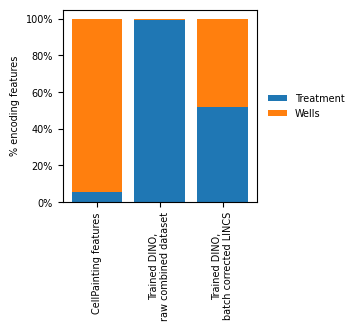

In [168]:
import matplotlib.ticker as mtick
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
cmap = cm.nipy_spectral

dominant_fov_percentages = []
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(cp_mi_matrices, cp_model_labels)):
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_well_MI = mi_matrix[1,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_well))
    dominant_fov_percentage = [len(high_protein) / len(new_indices),
                               len(high_well) / len(new_indices),]
    dominant_fov_percentages.append(dominant_fov_percentage)
                               
dominant_fov_percentages = np.array(dominant_fov_percentages) * 100
fig, ax = plt.subplots(1,1,figsize=(2.5,2.5))
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = 0,
    height = dominant_fov_percentages[:,0],
    label='Treatment'
       )
plt.bar(
    range(len(dominant_fov_percentages)),
    bottom = dominant_fov_percentages[:,:1].sum(axis=1),
    height = dominant_fov_percentages[:,1],
    label='Wells'
       )
plt.legend(bbox_to_anchor=(1.5,0.5), loc='center right', frameon=False)
plt.ylabel('% encoding features')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(range(len(cp_model_labels)),cp_model_labels, rotation=90)

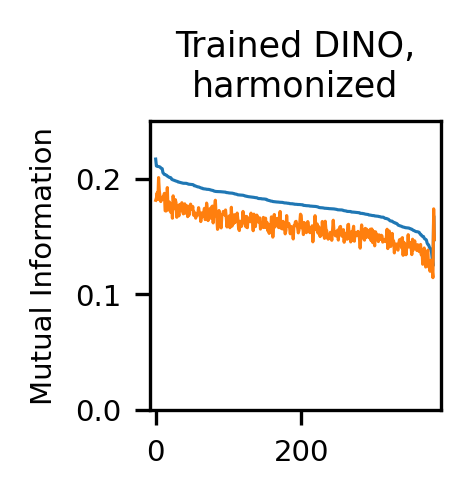

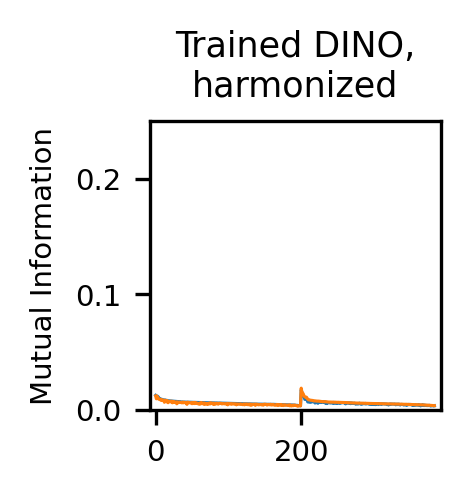

In [138]:
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(cp_mi_matrices, cp_model_labels)):
    fig, axes = plt.subplots(1,1,figsize=(7.5 / 6,7.5 / 6), sharey=True, dpi=300)
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_well_MI = mi_matrix[1,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_well))

    axes.plot(whole_HPA_protein_MI[new_indices], label=single_factor_labels[ind], linewidth=lw)
    axes.plot(whole_HPA_well_MI[new_indices], label=single_factor_labels[ind], linewidth=lw)
    axes.set_ylabel('Mutual Information')
    axes.set_title(label)
    axes.axis([-mi_matrix.shape[1] / 50,mi_matrix.shape[1] + mi_matrix.shape[1] / 50, 0, 0.25])
    
# plt.tight_layout()    


Text(0.5, 1.0, 'LINCS')

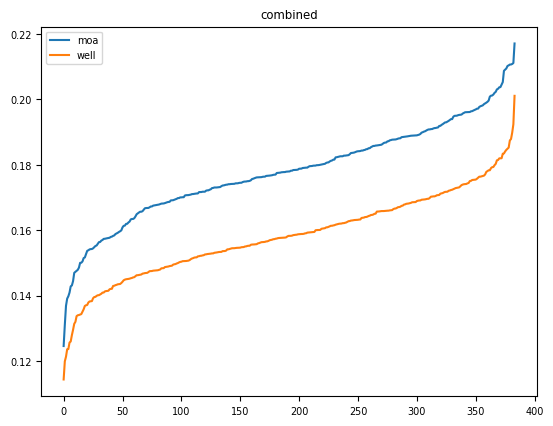

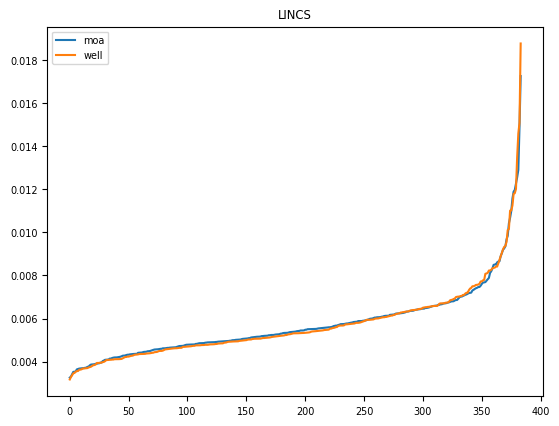

In [134]:
plt.figure()
plt.plot(sorted(cp_mi_matrices[0][0,:]), label='moa')
plt.plot(sorted(cp_mi_matrices[0][1,:]), label='well')
plt.legend()
plt.title('combined')

plt.figure()
plt.plot(sorted(cp_mi_matrices[1][0,:]), label='moa')
plt.plot(sorted(cp_mi_matrices[1][1,:]), label='well')
plt.legend()
plt.title('LINCS')


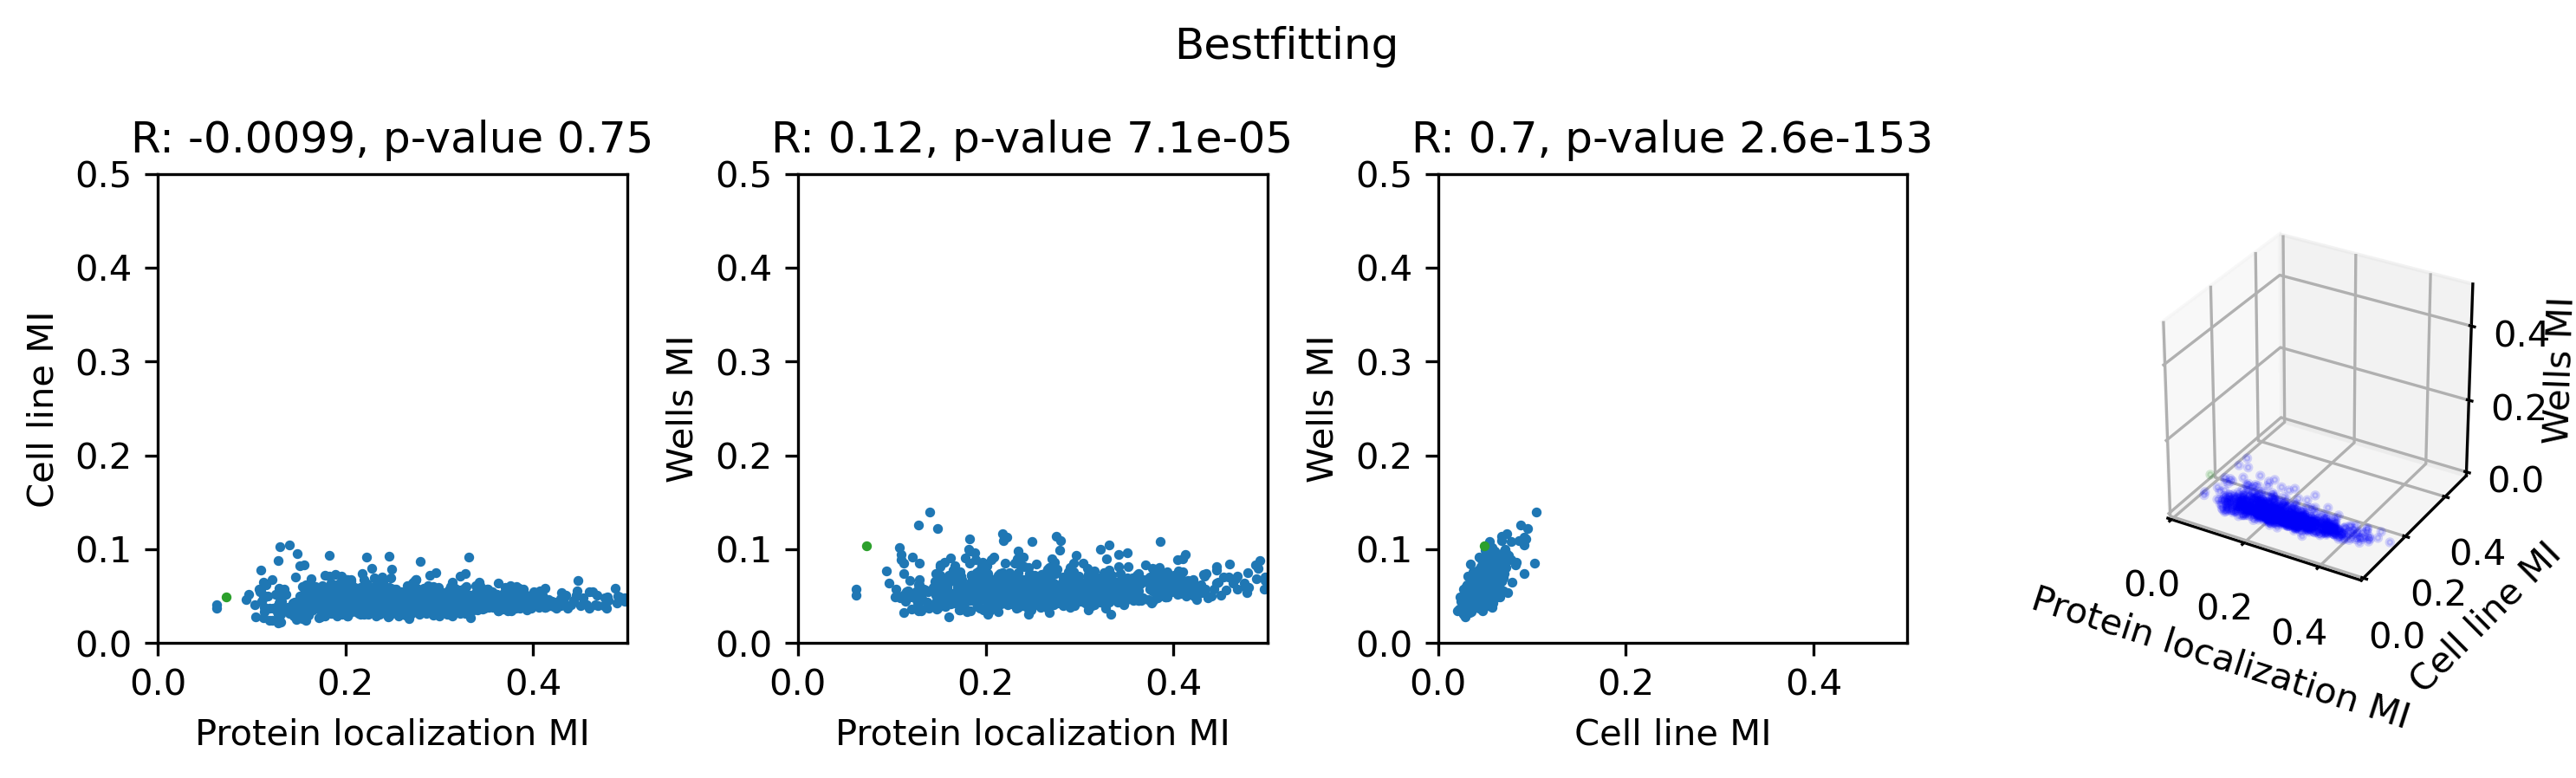

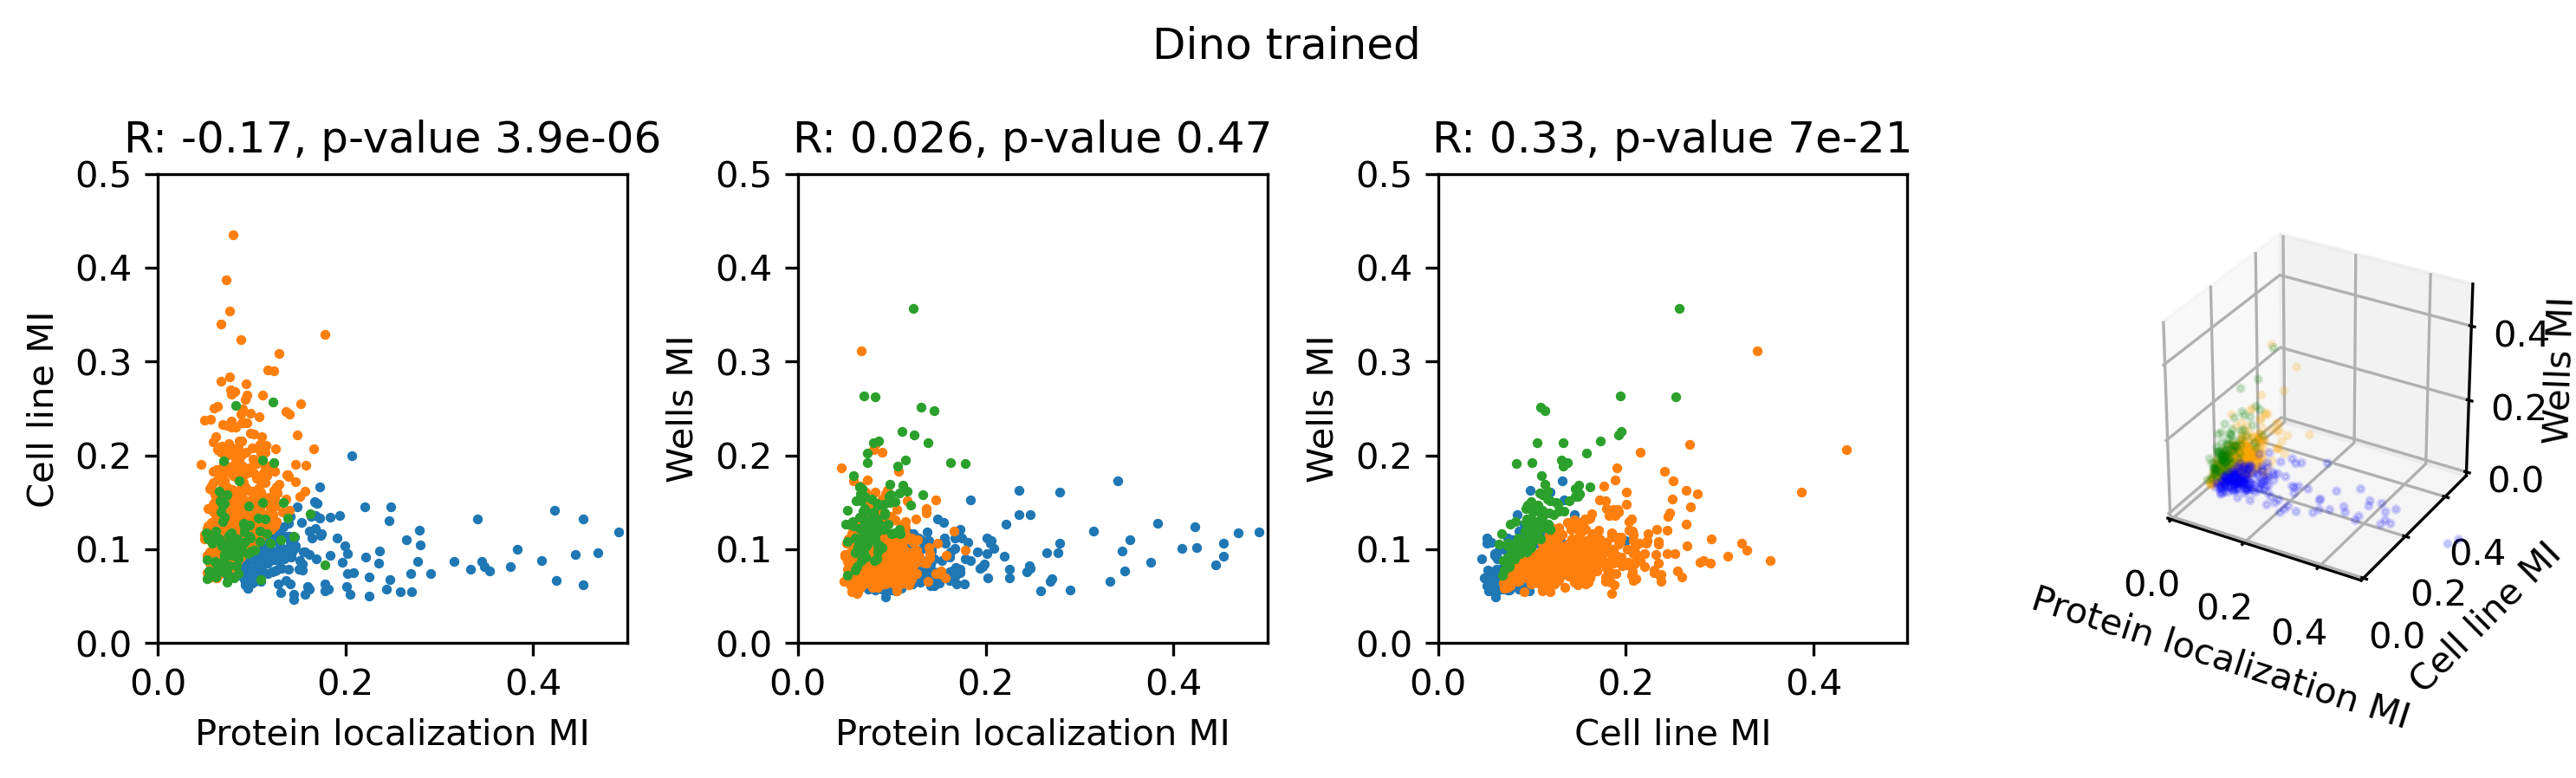

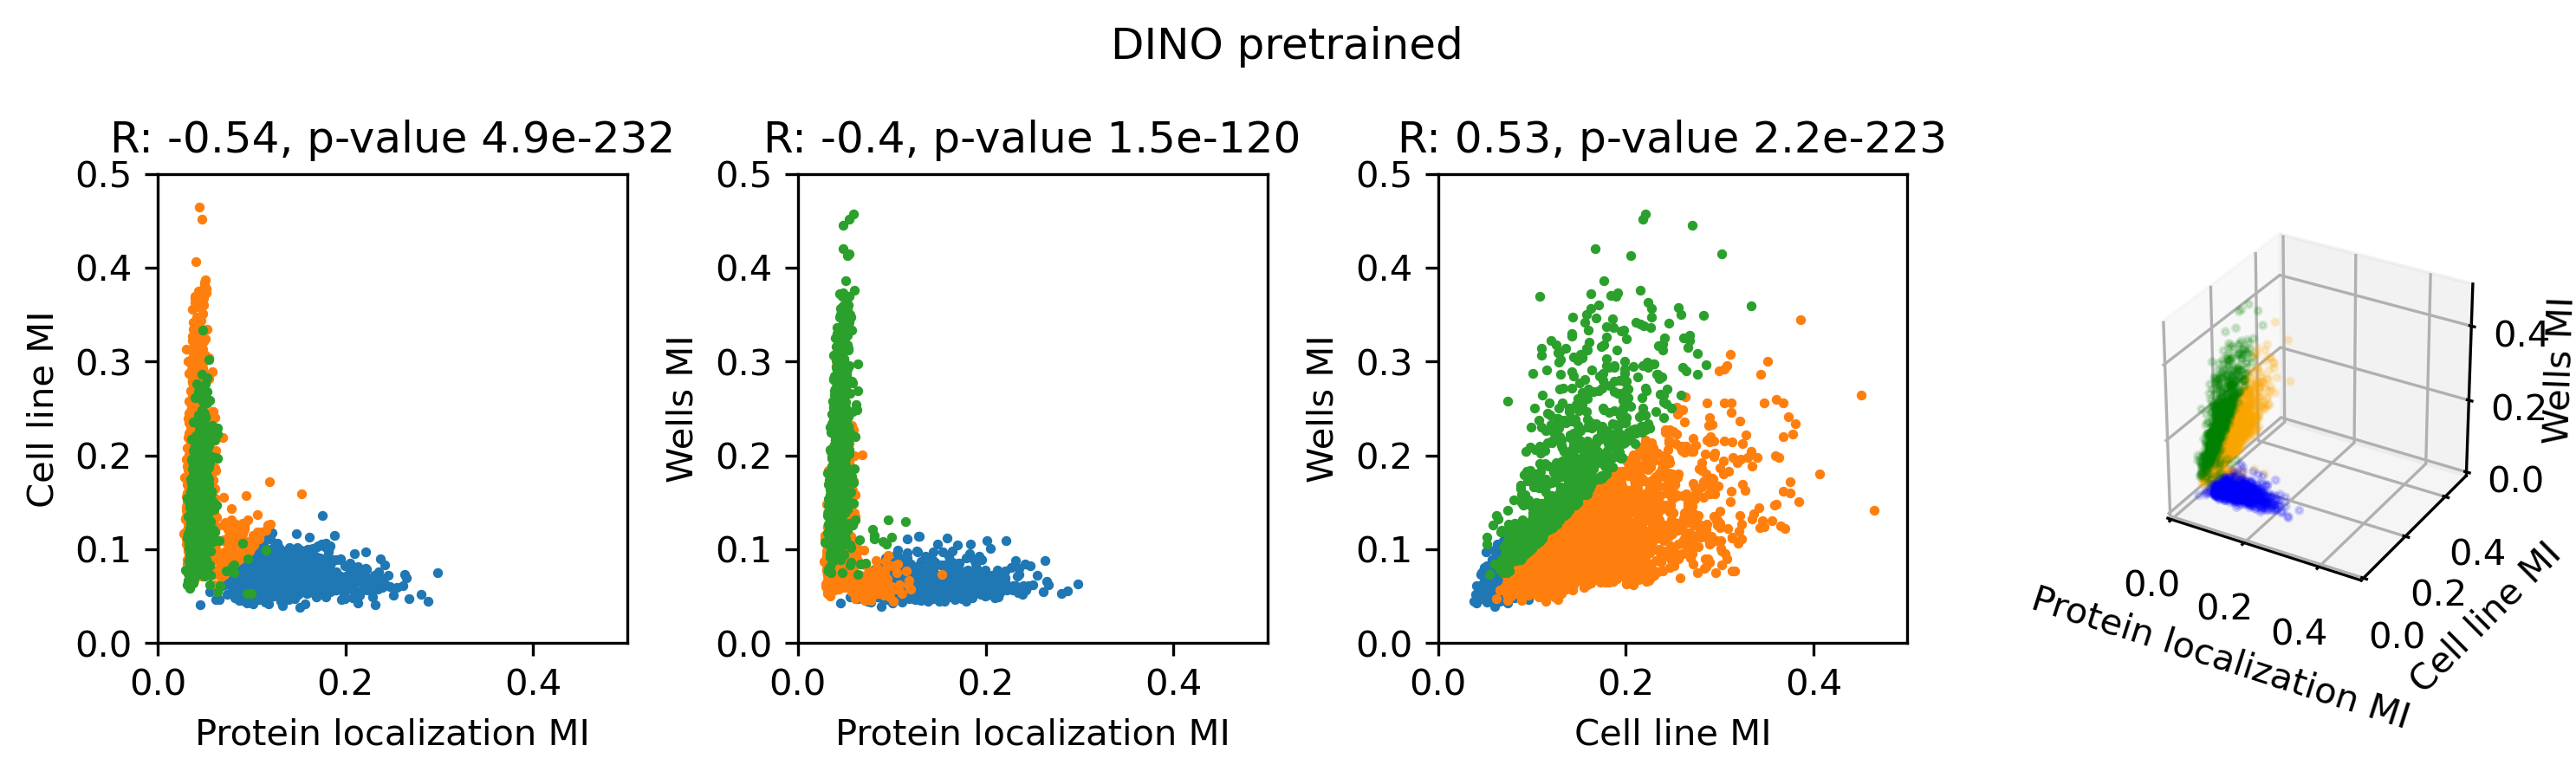

In [12]:
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr

hpa_model_labels = ['Bestfitting', 'Dino trained', 'DINO pretrained']
hpa_factor_labels = ['Protein localization', 'Cell type', 'Well']
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(hpa_mi_matrices, hpa_model_labels)):
    fig = plt.figure(figsize=(2.5 * 4, 2.5 * 2), dpi=300)
    G = gridspec.GridSpec(2, 4)

    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    color_values = np.linspace(0.1, 0.9, 3)
    new_indices_colors = np.concatenate(([color_values[0]] * len(high_protein), [color_values[1]] * len(high_cell), [color_values[2]] * len(high_well)))

    mi_matrix = mi_matrix.T

    inner_indices = [[0,1],[0,2],[1,2]]
    labels = ['Protein localization MI', 'Cell line MI', 'Wells MI']

    for ind in range(3):
        ax = plt.subplot(G[0, ind])
        inner_ind_1, inner_ind_2 = inner_indices[ind]
        for indices in [high_protein, high_cell, high_well]:
            ax.scatter(mi_matrix[indices,inner_ind_1],
                        mi_matrix[indices,inner_ind_2],
                        s=3,
                        alpha=1)   
        ax.set_xlabel(labels[inner_ind_1])
        ax.set_ylabel(labels[inner_ind_2])
        ax.axis([0, 0.5, 0, 0.5])
        R, p = pearsonr(mi_matrix[:,inner_ind_1], mi_matrix[:,inner_ind_2])
        ax.set_title(f'R: {R:0.2}, p-value {p:0.2}')
    plt.tight_layout()

    new_indices_colors = np.concatenate((['blue'] * len(high_protein), ['orange'] * len(high_cell), ['green'] * len(high_well)))

    ax = plt.subplot(G[0, 3], projection='3d')
#     ax.set_box_aspect([2,1,1], zoom=5)
    ax.scatter(
                mi_matrix[new_indices,0], 
                 mi_matrix[new_indices,1], 
                 mi_matrix[new_indices,2],
                 c=new_indices_colors,
                 s=3,
                 alpha=0.15)
#     ax.set_aspect('equal')

    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.zaxis.labelpad=0.1
    limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
    ax.axes.set_xlim3d(left=0.0, right=0.5) 
    ax.axes.set_ylim3d(bottom=0.0, top=0.5) 
    ax.axes.set_zlim3d(bottom=0.0, top=0.5) 

    ax.set_box_aspect([1,1,1], zoom=0.8)
#     ax.set_box_aspect(aspect=None, zoom=0.8)
#     ax.set_box_aspect(aspect = (100,1,1))
    plt.suptitle(mi_label)
    plt.tight_layout()


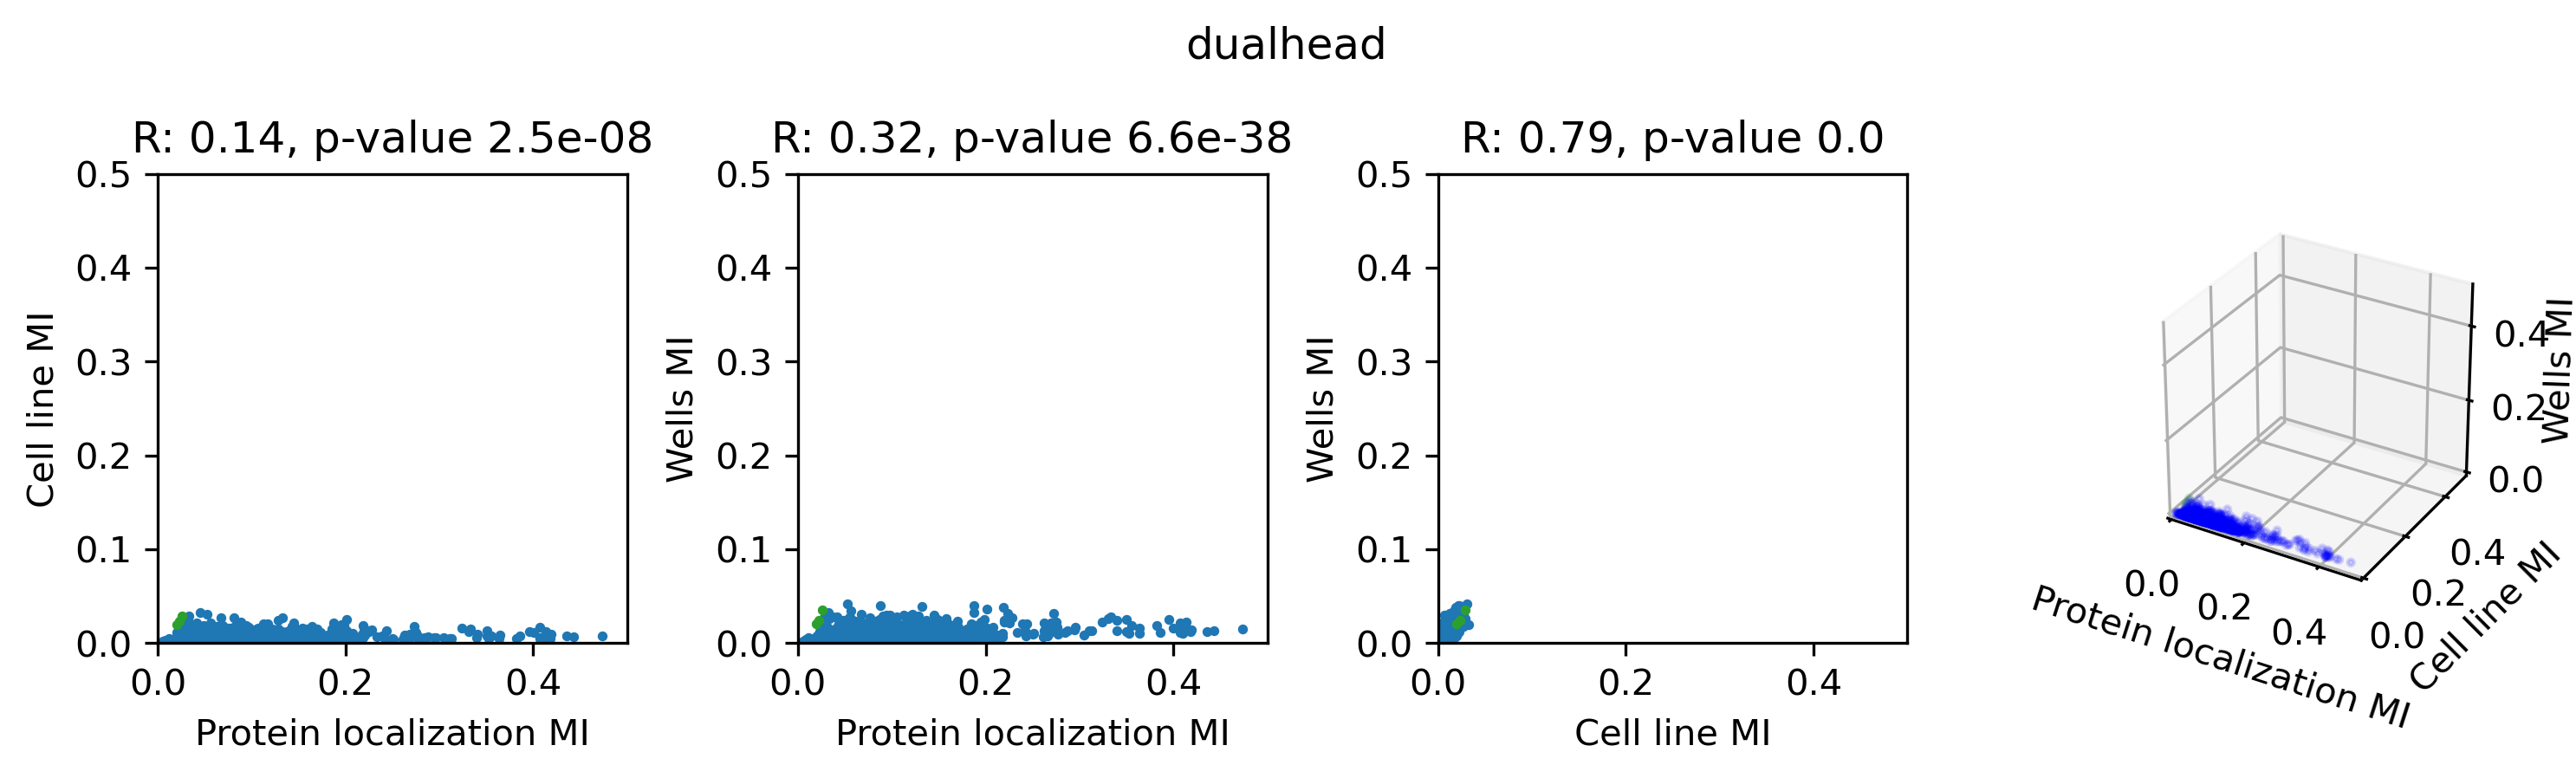

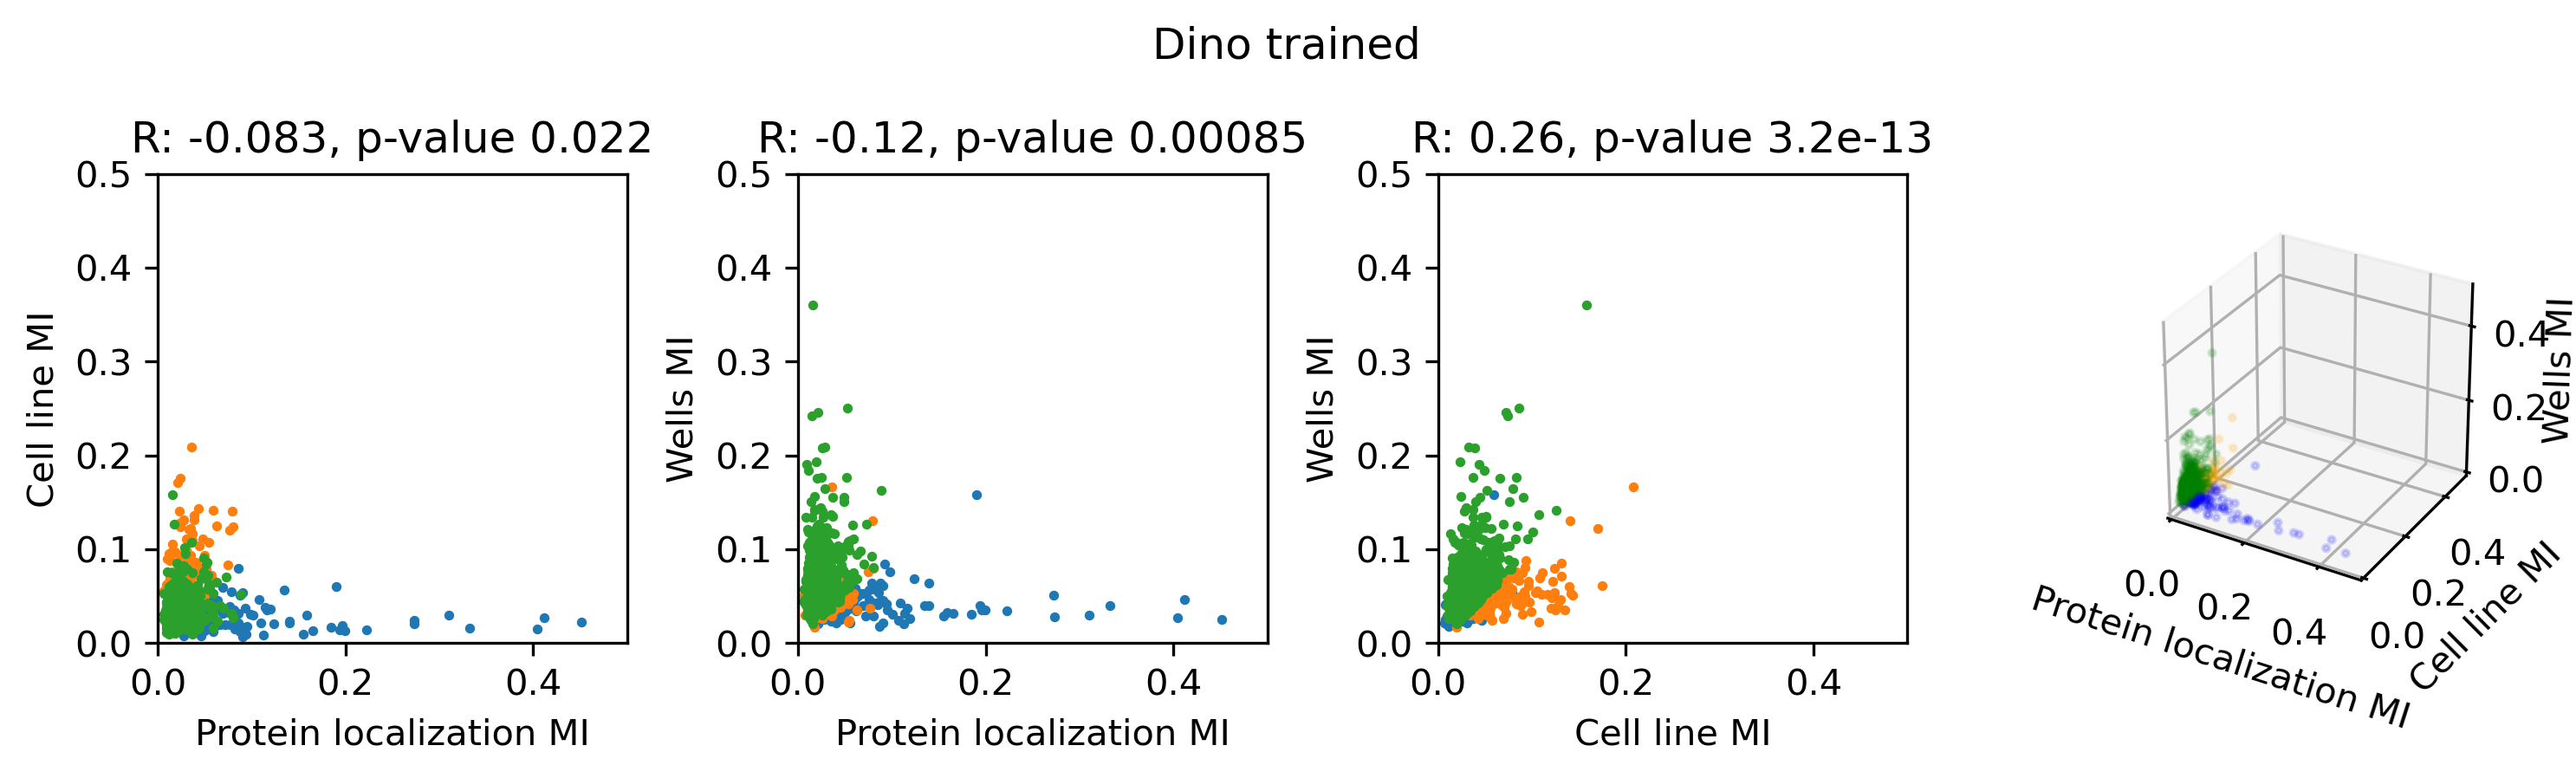

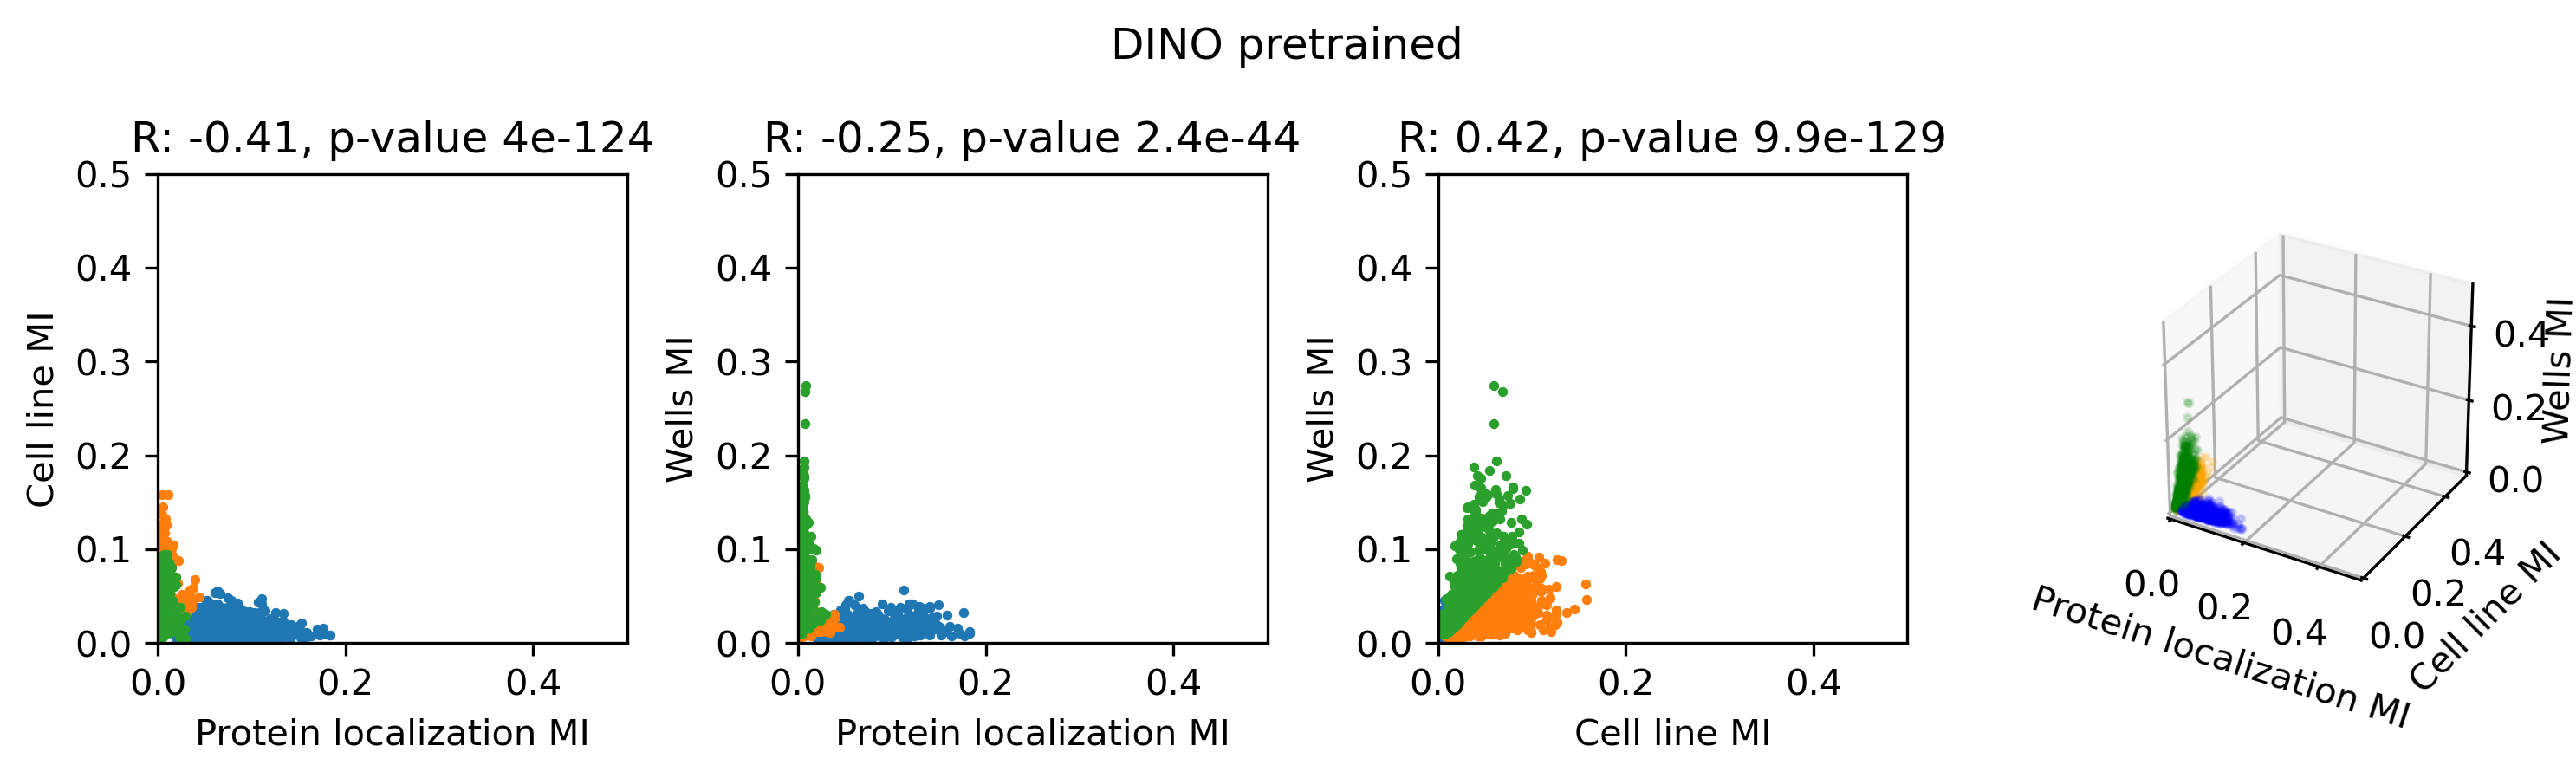

In [13]:
import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
single_model_labels = ['dualhead', 'Dino trained', 'DINO pretrained']
single_factor_labels = ['Protein localization', 'Cell type', 'Well']

for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(single_mi_matrices, single_model_labels)):
    fig = plt.figure(figsize=(2.5 * 4, 2.5 * 2), dpi=300)
    G = gridspec.GridSpec(2, 4)
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    color_values = np.linspace(0.1, 0.9, 3)
    new_indices_colors = np.concatenate(([color_values[0]] * len(high_protein), [color_values[1]] * len(high_cell), [color_values[2]] * len(high_well)))

    mi_matrix = mi_matrix.T

    inner_indices = [[0,1],[0,2],[1,2]]
    labels = ['Protein localization MI', 'Cell line MI', 'Wells MI']

    for ind in range(3):
        ax = plt.subplot(G[0, ind])
        inner_ind_1, inner_ind_2 = inner_indices[ind]
        for indices in [high_protein, high_cell, high_well]:
            ax.scatter(mi_matrix[indices,inner_ind_1],
                        mi_matrix[indices,inner_ind_2],
                        s=3,
                        alpha=1)   
        ax.set_xlabel(labels[inner_ind_1])
        ax.set_ylabel(labels[inner_ind_2])
        ax.axis([0, 0.5, 0, 0.5])
        R, p = pearsonr(mi_matrix[:,inner_ind_1], mi_matrix[:,inner_ind_2])
        ax.set_title(f'R: {R:0.2}, p-value {p:0.2}')
    plt.tight_layout()

    new_indices_colors = np.concatenate((['blue'] * len(high_protein), ['orange'] * len(high_cell), ['green'] * len(high_well)))

    ax = plt.subplot(G[0, 3], projection='3d')
#     ax.set_box_aspect([2,1,1], zoom=5)
    ax.scatter(
                mi_matrix[new_indices,0], 
                 mi_matrix[new_indices,1], 
                 mi_matrix[new_indices,2],
                 c=new_indices_colors,
                 s=3,
                 alpha=0.15)
#     ax.set_aspect('equal')

    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.zaxis.labelpad=0.1
    limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
    ax.axes.set_xlim3d(left=0.0, right=0.5) 
    ax.axes.set_ylim3d(bottom=0.0, top=0.5) 
    ax.axes.set_zlim3d(bottom=0.0, top=0.5) 

    ax.set_box_aspect([1,1,1], zoom=0.8)
#     ax.set_box_aspect(aspect=None, zoom=0.8)
#     ax.set_box_aspect(aspect = (100,1,1))
    plt.suptitle(mi_label)
    plt.tight_layout()


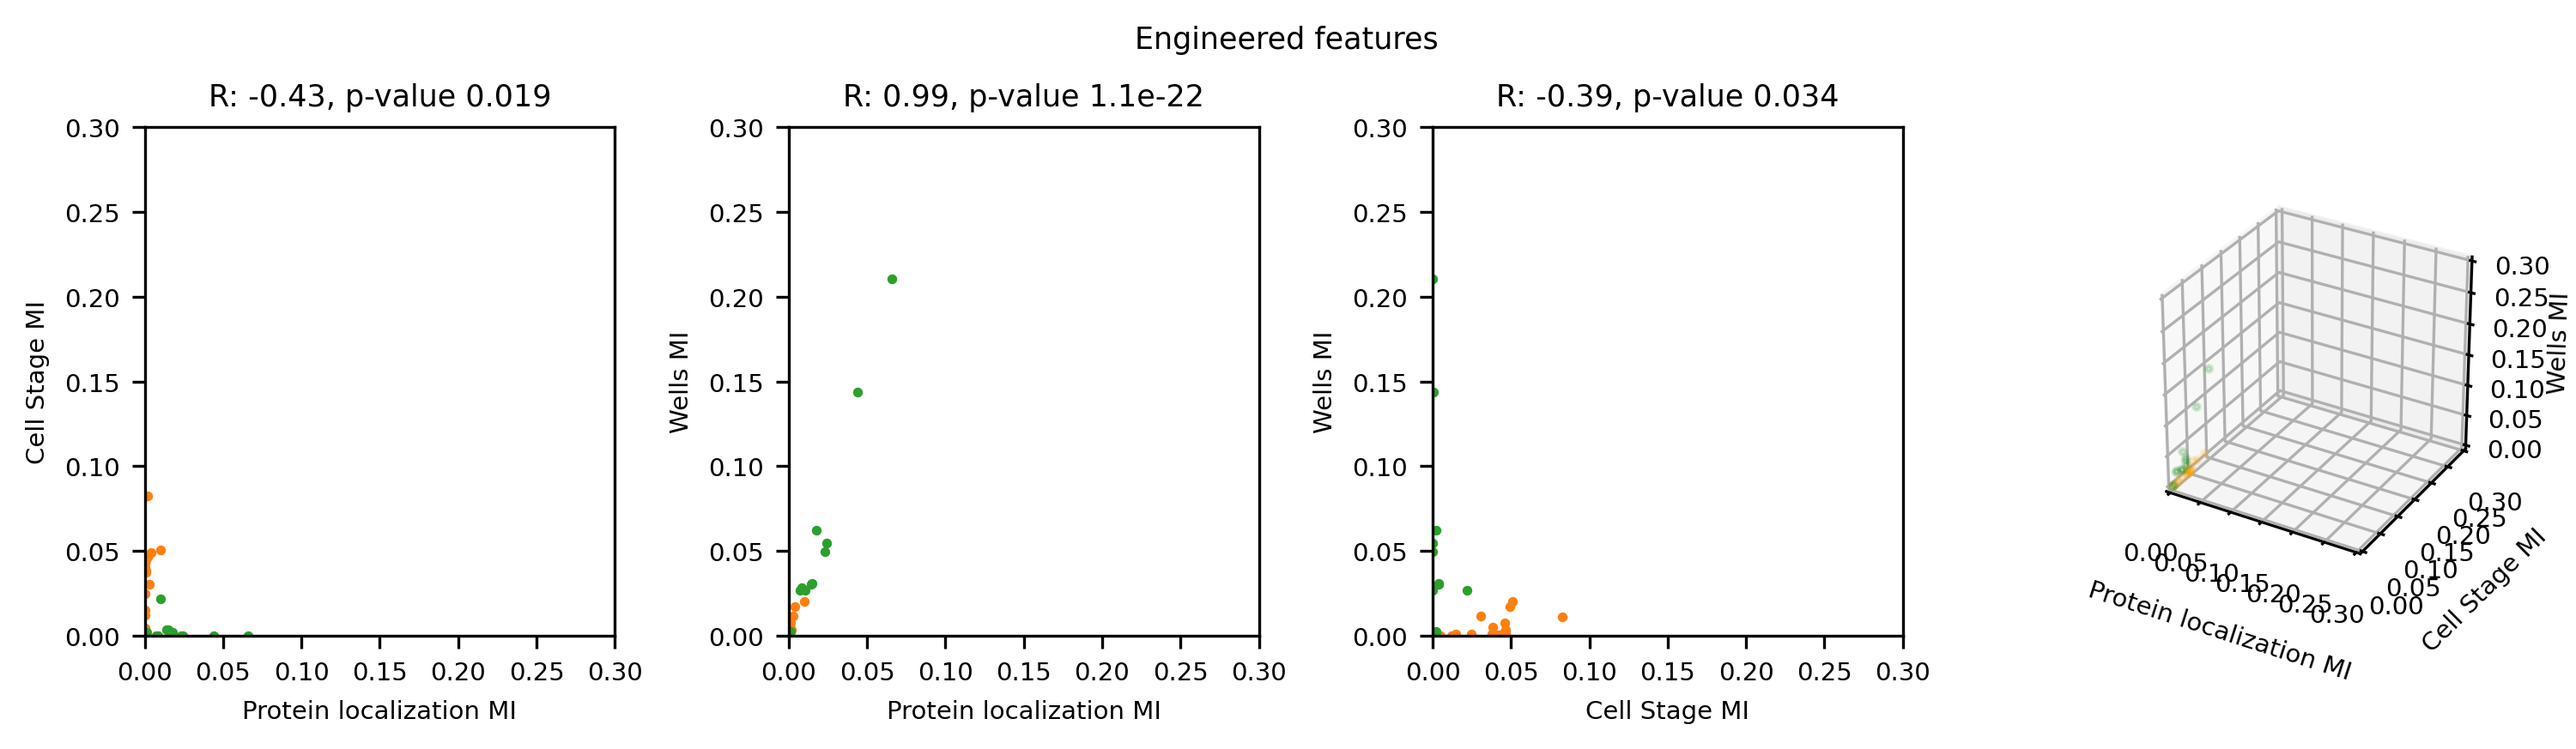

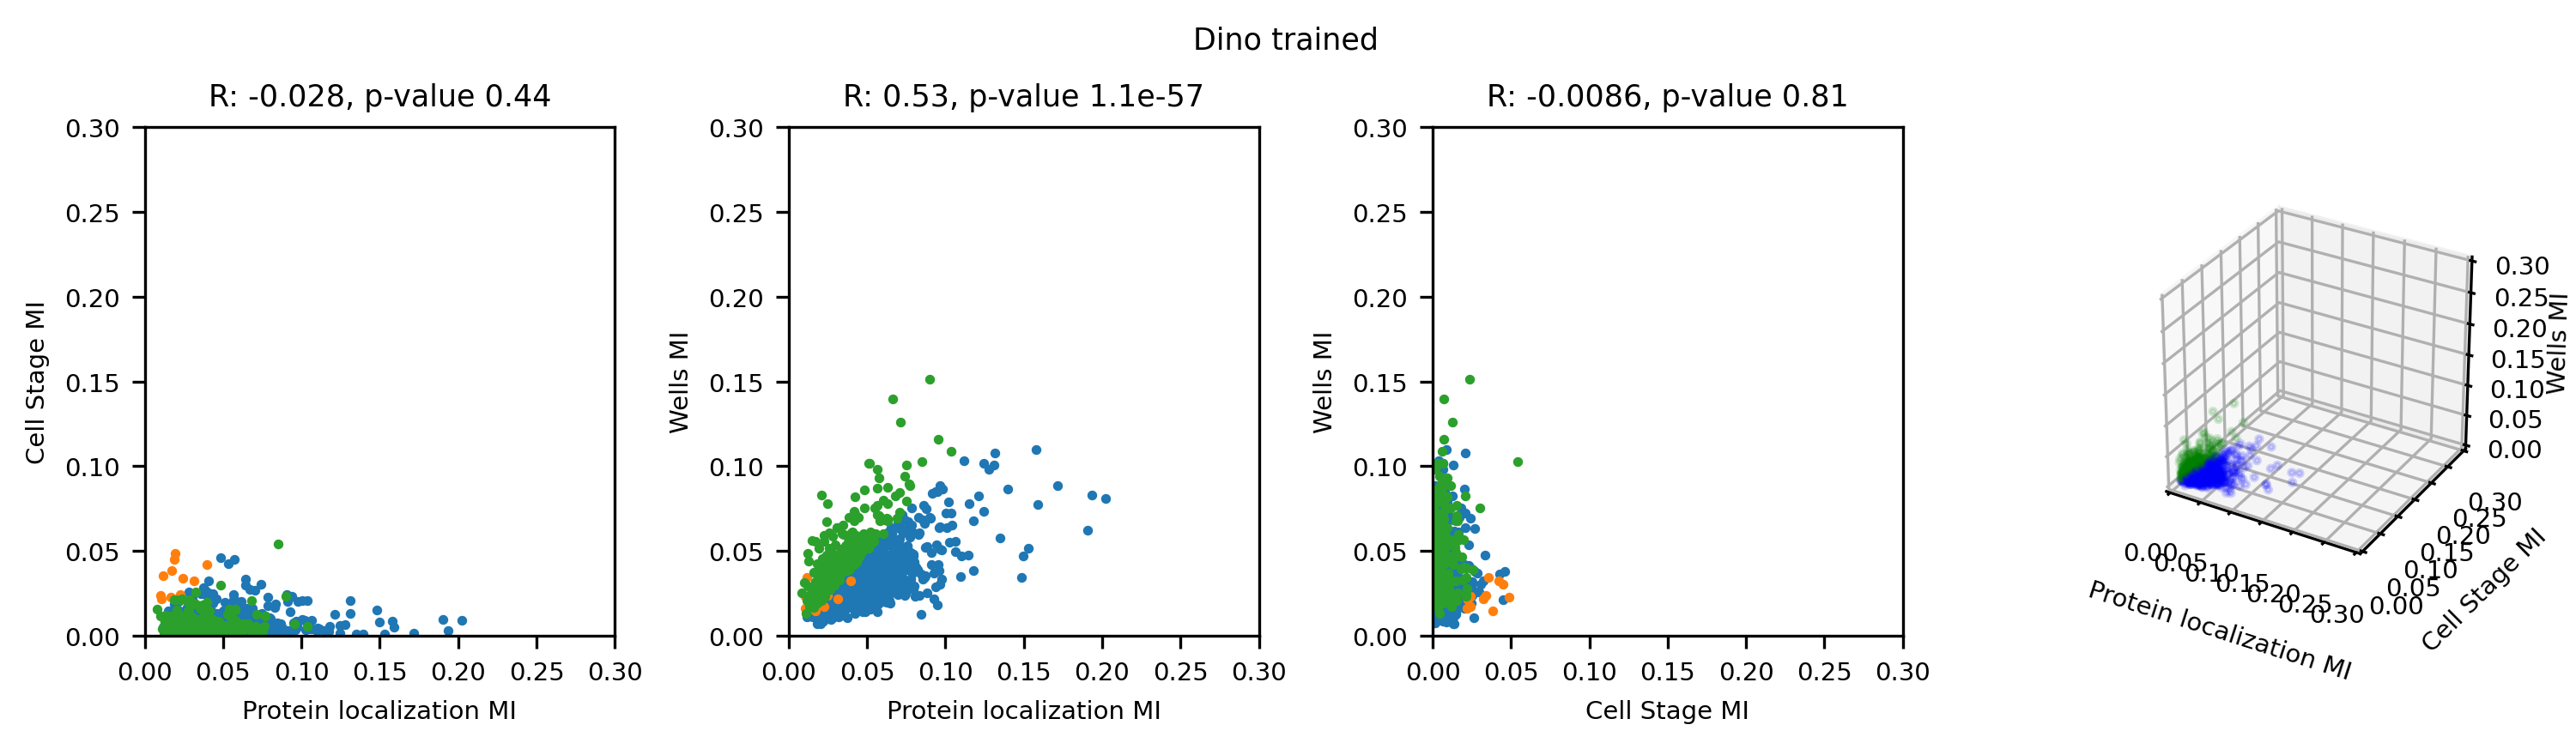

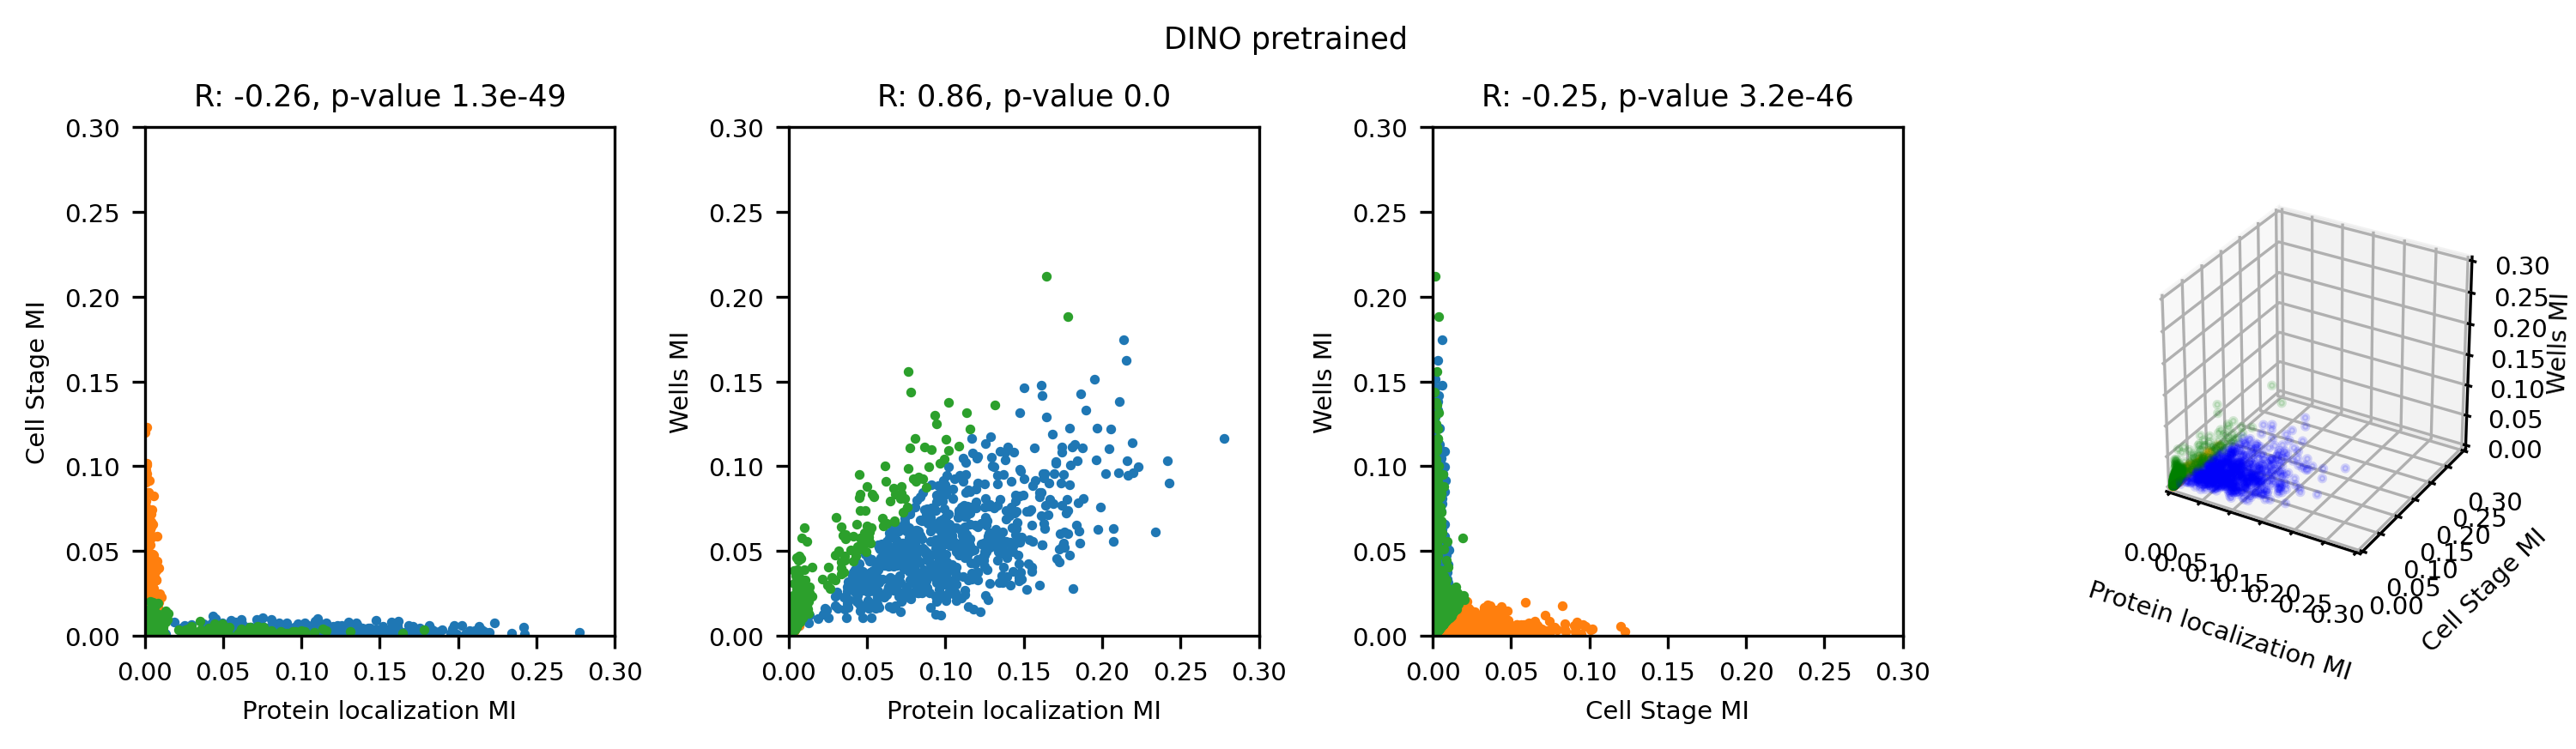

In [16]:
import matplotlib.gridspec as gridspec
import matplotlib
font = {'size'   : 7}
matplotlib.rc('font', **font)

lw = 0.75
allen_model_labels = ['Engineered features', 'Dino trained', 'DINO pretrained']
allen_factor_labels = ['Protein structure', 'Cell stage', 'Well']
from scipy.stats import pearsonr
for matrix_ind, (mi_matrix, mi_label) in enumerate(zip(allen_mi_matrices, allen_model_labels)):
    fig = plt.figure(figsize=(2.5 * 4, 2.5 * 2), dpi=300)
    G = gridspec.GridSpec(2, 4)
    whole_HPA_protein_MI = mi_matrix[0,:]
    whole_HPA_cell_MI = mi_matrix[1,:]
    whole_HPA_well_MI = mi_matrix[2,:]
    high_protein = np.where((whole_HPA_protein_MI > whole_HPA_cell_MI) & (whole_HPA_protein_MI > whole_HPA_well_MI))[0]
    high_protein = high_protein[np.argsort(whole_HPA_protein_MI[high_protein])][::-1]
    high_cell = np.where((whole_HPA_cell_MI > whole_HPA_protein_MI) & (whole_HPA_cell_MI > whole_HPA_well_MI))[0]
    high_cell = high_cell[np.argsort(whole_HPA_cell_MI[high_cell])][::-1]
    high_well = np.where((whole_HPA_well_MI > whole_HPA_protein_MI) & (whole_HPA_well_MI > whole_HPA_cell_MI))[0]
    high_well = high_well[np.argsort(whole_HPA_well_MI[high_well])][::-1]
    new_indices = np.concatenate((high_protein, high_cell, high_well))
    color_values = np.linspace(0.1, 0.9, 3)
    new_indices_colors = np.concatenate(([color_values[0]] * len(high_protein), [color_values[1]] * len(high_cell), [color_values[2]] * len(high_well)))

    mi_matrix = mi_matrix.T

    inner_indices = [[0,1],[0,2],[1,2]]
    labels = ['Protein localization MI', 'Cell Stage MI', 'Wells MI']

    for ind in range(3):
        ax = plt.subplot(G[0, ind])
        inner_ind_1, inner_ind_2 = inner_indices[ind]
        for indices in [high_protein, high_cell, high_well]:
            ax.scatter(mi_matrix[indices,inner_ind_1],
                        mi_matrix[indices,inner_ind_2],
                        s=3,
                        alpha=1)   
        ax.set_xlabel(labels[inner_ind_1])
        ax.set_ylabel(labels[inner_ind_2])
        ax.axis([0, 0.3, 0, 0.3])
        R, p = pearsonr(mi_matrix[:,inner_ind_1], mi_matrix[:,inner_ind_2])
        ax.set_title(f'R: {R:0.2}, p-value {p:0.2}')
    plt.tight_layout()

    new_indices_colors = np.concatenate((['blue'] * len(high_protein), ['orange'] * len(high_cell), ['green'] * len(high_well)))

    ax = plt.subplot(G[0, 3], projection='3d')
#     ax.set_box_aspect([2,1,1], zoom=5)
    ax.scatter(
                mi_matrix[new_indices,0], 
                 mi_matrix[new_indices,1], 
                 mi_matrix[new_indices,2],
                 c=new_indices_colors,
                 s=3,
                 alpha=0.15)
#     ax.set_aspect('equal')

    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.zaxis.labelpad=0.1
    limits = np.array([getattr(ax, f'get_{axis}lim')() for axis in 'xyz'])
    ax.axes.set_xlim3d(left=0.0, right=0.3) 
    ax.axes.set_ylim3d(bottom=0.0, top=0.3) 
    ax.axes.set_zlim3d(bottom=0.0, top=0.3) 

    ax.set_box_aspect([1,1,1], zoom=0.8)
#     ax.set_box_aspect(aspect=None, zoom=0.8)
#     ax.set_box_aspect(aspect = (100,1,1))
    plt.suptitle(mi_label)
    plt.tight_layout()
